# Comparativa de Catálogos de Contenido en Streaming: Netflix vs. Amazon Prime

<div style="display: flex; justify-content: center; align-items: center;">
  <img src="images/Netflix-Logo.jpg" alt="Imagen 1" width="400" style="margin-right: 0px;"/>
  <img src="images/amazon_prime_logo.png" alt="Imagen 2" width="390"/>
</div>

## 1. Descripción del proyecto

### 1.1 Introducción


En este proyecto nos centraremos en aplicar las técnicas de programación aprendidas en la asignatura Python para IA para realizar un análisis exhaustivo y comparativo de los catálogos de contenido de dos de las principales plataformas de streaming: Netflix y Amazon Prime Video. Utilizando herramientas de análisis de datos, el estudio buscará identificar similitudes y diferencias clave en los catálogos de ambas plataformas.

Para llevar a cabo este análisis, se utilizarán dos datasets que contienen las siguientes columnas:
- **show_id**: Identificador único para cada título.
- **type**: Si es una película o una serie.
- **title**: Nombre del contenido.
- **cast**: Nombre de los actores o actrices del reparto.
- **director**: Nombre del director o directores.
- **country**: País de producción.
- **date_added**: Fecha en la que se añadió a la plataforma de streaming.
- **release_year**: Año de lanzamiento.
- **rating**: Clasificación por edad del contenido.
- **duration**: Duración del contenido (minutos o temporadas).
- **listed_in**: Género del contenido.
- **description**: Sinopsis del contenido.

Además, se utilizará un dataset adicional: un shapefile del mapa mundial. Este shapefile se relacionará con los datasets principales a través de la columna que contiene los nombres de los países, para así obtener las geometrías correspondientes a cada uno de ellos.

### 1.2 Objetivos del proyecto

- **Exploración de los Datos**: Realizar un análisis exploratorio de los datos utilizando técnicas estadísticas y visualizaciones para comprender la distribución, las relaciones y las posibles anomalías en el dataset.

- **Definición y Aplicación de los Pasos de Limpieza y Transformación de Datos**: Identificar y aplicar los métodos necesarios para limpiar y transformar los datos, incluyendo el manejo de valores faltantes, la normalización, y la transformación de variables categóricas.

- **Unión de Datasets**: Combinar los datasets utilizando técnicas de unión de datos en Pandas.

- **Visualización de los Datos**: Crear visualizaciones significativas que permitan entender mejor los patrones y tendencias en los datos.

- **Interpretación de Resultados y Conclusiones**: Analizar las visualizaciones y los resultados obtenidos del EDA para sacar conclusiones significativas que respondan a las preguntas planteadas en el proyecto.

## 2. Importación de Bibliotecas

En este proyecto, utilizamos varias bibliotecas de Python que son fundamentales para el análisis de datos y la visualización de resultados. Cada una de estas bibliotecas proporciona herramientas específicas que facilitan la manipulación, el análisis y la representación gráfica de datos.

Para el desarrollo del proyecto es necesario tener instalados los siguienes parquetes:

In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install geopandas
# !pip install pandas
# !pip install plotly
# !pip install seaborn
# !pip install wordcloud
# !pip install contextily

In [2]:
# Bibliotecas estándar
import calendar
from datetime import datetime
import random as rd


# Bibliotecas de terceros
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud
import contextily as ctx
import os


## 3. Definición de Funciones

En este apartado se presentan las funciones personalizadas que se han creado específicamente para este proyecto. Estas funciones están diseñadas para abordar tareas específicas y se implementan con el objetivo de mejorar la modularidad, la legibilidad y la mantenibilidad del código.

In [3]:
def fill_nan_dates(row):
    """
    Completa las fechas en la que el contenido se añadió a la plataforma 
    faltantes, si el valor del año es 0, generando una fecha aleatoria 
    dentro de un rango válido. 
    """
    
    rd.seed(123) # Semilla fija para reproducibilidad

    año_actual = datetime.now().year # Año actual

    # Año en el que "comienza" la plataforma de streaming
    if row['plataforma'] == 'Netflix':
        year_start = 2008
    else:
        year_start = 2016


    if row['year'] == 0:
        if row['release_year'] > year_start:
            row['year'] = rd.randint(row['release_year'], año_actual)
        else:
            row['year'] = rd.randint(year_start, año_actual)

        row['month'] = rd.randint(1, 12)
        row['day'] = rd.randint(1, calendar.monthrange(row['year'], row['month'])[1])  # Días válidos del mes y año

    return row



In [4]:
def calcular_proporcion_nulos(df, *columnas):
    """ 
    Calcula la proporción de valores nulos en las columnas especificadas de 
    un DataFrame.
    """

    proporciones = {}
    
    for columna in columnas:
            
        # Calcular el número de valores nulos en la columna
        nulos = df[columna].isnull().sum()
        
        # Calcular el número total de filas en el DataFrame
        total_filas = df.shape[0]
        
        # Calcular la proporción de valores nulos
        proporcion_nulos = nulos / total_filas
        
        # Guardar la proporción en el diccionario
        proporciones[columna] = proporcion_nulos
    
    return proporciones

In [5]:
def categorizar_rating(rating):
    """
    Categoriza un rating en una de las categorías predefinidas basadas en un 
    diccionario de correspondencias.
    """

    rating_dict = {
        '0+': ['G', 'PG', 'TV-Y', 'TV-G', 'TV-PG', 'ALL', 'ALL_AGES'],
        '7+': ['TV-Y7', 'TV-Y7-FV', '7+'],
        '13+': ['PG-13', 'TV-14', '13+'],
        '16+': ['16+', '16', 'AGES_16_'],
        '18+': ['TV-MA','R', 'NC-17', '18+', 'AGES_18_']
    }
    
    for categoria, valores in rating_dict.items():
        if rating in valores:
            return categoria
    return 'Sin clasificación'

In [6]:
def top_10_general(df, category_col,  top_n=10, exclude_categories=None, category_mapping=None, palette='icefire'):
    """
    Función para graficar el top n de número de títulos de una categoría en 
    un DataFrame.
    
    """
    
    # Si exclude_categories o category_mapping no se proporcionan, usar valores predeterminados
    if exclude_categories is None:
        exclude_categories = []  # No excluir ninguna categoría por defecto
    if category_mapping is None:
        category_mapping = {}  # No hacer mapeo por defecto
    
    # Separar las categorías si están en una cadena de texto
    df_category = df[category_col].str.split(',', expand=True).stack().to_frame()
    df_category.columns = [category_col]
    
    #eliminar espacios adicionales y estandarizar a título)
    df_category[category_col] = df_category[category_col].str.strip().str.title()
    
    # Sii fuera necesario, el mapeo de categorías
    df_category[category_col] = df_category[category_col].replace(category_mapping)
    
    # Agrupar por categoría y contar el número de ocurrencias
    category_counts = df_category.groupby([category_col]).size().reset_index(name='Total')
    
    # Filtrar las categorías a excluir
    category_counts = category_counts[~category_counts[category_col].isin(exclude_categories)]
    
    # Ordenar por la cuenta de títulos en orden descendente
    category_counts = category_counts.sort_values(by='Total', ascending=False)
    
    # Seleccionar las 'top_n' categorías con mayor frecuencia
    top_categories = category_counts[category_col].unique()[:top_n]
    
    # Configurar el gráfico
    plt.figure(figsize=(8, 5))
    
   
    sns.countplot(
        y=category_col,
        order=top_categories,
        data=df_category[df_category[category_col].isin(top_categories)],
        palette=palette,
        edgecolor='black'
    )
    
   
    plt.title(f'Número de Títulos por {category_col.title()}', fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Número de Títulos', fontsize=16, fontweight='bold')
    plt.ylabel(category_col.title(), fontsize=16, fontweight='bold')
    
    
    plt.show()


In [7]:
def top_10_por_plataforma(df, category_col, group_col, top_n=10, exclude_categories=None, category_mapping=None, palette='viridis'):
    """
    Función para graficar las categorías más populares por grupo en un 
    conjunto de datos.

    """
    
    if exclude_categories is None:
        exclude_categories = [] 
    if category_mapping is None:
        category_mapping = {}  
    
    df_group = df.copy()
    
    df_group[category_col] = df_group[category_col].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    
    
    df_exploded = df_group.explode(category_col)
    
    
    df_exploded = df_exploded[~df_exploded[category_col].isin(exclude_categories)]
    
    
    df_exploded[category_col] = df_exploded[category_col].str.strip().str.title()
    
    
    grouped_data = df_exploded.groupby([category_col, group_col]).size().reset_index(name='count')
    
    
    grouped_data[category_col] = grouped_data[category_col].map(category_mapping).fillna(grouped_data[category_col])
    
    
    sorted_data = grouped_data.sort_values(by='count', ascending=False)
    
    
    top_categories = sorted_data[category_col].unique()[:top_n]
    
    
    df_top_categories = sorted_data[sorted_data[category_col].isin(top_categories)]
    
   
    plt.figure(figsize=(12, 8))
    
    
    sns.barplot(
        data=df_top_categories,
        y=category_col,
        x='count',
        hue=group_col,
        order=top_categories,
        palette=palette,
        edgecolor='black'
    )
    
    
    plt.title(f'Número de Ocurrencias por {category_col.title()} y {group_col.title()}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Número de Ocurrencias', fontsize=14, fontweight='bold')
    plt.ylabel(category_col.title(), fontsize=14, fontweight='bold')
    
   
    plt.show()


## 4. Carga de Datos

In [8]:
ruta_netflix = os.path.join("datasets", "netflix_titles.csv")
ruta_prime = os.path.join("datasets", "amazon_prime_titles.csv")
ruta_world = os.path.join("datasets", "ne_110m_admin_0_countries", "ne_110m_admin_0_countries.shp")
ruta_world_csv = os.path.join("datasets", "ne_110m_admin_0_countries","ne_110m_admin_0_countries.csv")

In [9]:
df_netflix = pd.read_csv(ruta_netflix, delimiter = ',')
df_prime = pd.read_csv(ruta_prime, delimiter = ',')

In [10]:
# Cargar el shapefile del mapa mundial
world = gpd.read_file(ruta_world)
world_csv = pd.read_csv(ruta_world_csv)

## 5. Exploración Inicial de los Datos

### 5.1 Netflix Dataset

El primer dataset con el que vamos a trabajar tiene 12 columnas y 8807 entradas.

In [11]:
df_netflix.shape

(8807, 12)

En esta primera visualización de los datos, observamos que las columnas **director**, **cast** y **country** contienen valores faltantes (NaN). Asimismo, las columnas **cast** y **listed_in** pueden tener múltiples valores para cada título.

In [12]:
df_netflix.sample(n = 10, random_state = 20)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
8340,s8341,Movie,The Heat: A Kitchen (R)evolution,Maya Gallus,NaN,Canada,"May 7, 2019",2018,TV-MA,71 min,Documentaries,Seven female chefs describe what it’s like bre...
1034,s1035,Movie,Synchronic,"Justin Benson, Aaron Moorhead","Anthony Mackie, Jamie Dornan, Katie Aselton, A...",United States,"April 16, 2021",2020,R,102 min,Thrillers,Two paramedics begin to question their realiti...
7515,s7516,Movie,Movie 43,"Peter Farrelly, Will Graham, Steve Carr, Griff...","Greg Kinnear, Dennis Quaid, Common, Seth MacFa...",United States,"April 9, 2019",2013,R,94 min,Comedies,An eye-popping cast stars in this sketch-comed...
2060,s2061,Movie,Always Be My Maybe,Dan Villegas,"Gerald Anderson, Arci Muñoz, Cacai Bautista, R...",Philippines,"September 1, 2020",2016,TV-14,112 min,"International Movies, Romantic Movies",After being unexpectedly dumped by their respe...
7580,s7581,Movie,Newtown,Kim A. Snyder,NaN,United States,"April 7, 2017",2016,NR,84 min,Documentaries,This intimate portrait sheds light on the trau...
3557,s3558,Movie,Travis Scott: Look Mom I Can Fly,White Trash Tyler,Travis Scott,United States,"August 28, 2019",2019,TV-MA,85 min,"Documentaries, Music & Musicals","While crafting his Grammy-nominated album ""Ast..."
2441,s2442,Movie,What's Up?,Izidore K. Musallam,"Hisham Abdulrahman, Turki Al-Yusuf, Mais Hamda...","Saudi Arabia, United Arab Emirates","June 2, 2020",2006,TV-PG,95 min,"Comedies, Dramas, International Movies","Flirting with modernity, a young woman must ke..."
1005,s1006,Movie,Keymon and Nani in Space Adventure,NaN,NaN,NaN,"April 20, 2021",2013,TV-Y,76 min,"Children & Family Movies, Comedies","For Rohan and his magical pal, Keymon, a trip ..."
4174,s4175,TV Show,Innocent,Seren Yüce,"Ali Atay, Haluk Bilginer, Nur Sürer, Okan Yala...",Turkey,"January 23, 2019",2017,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas","In a peaceful, rustic town, a retired officer ..."
2835,s2836,Movie,Miles Davis: Birth of the Cool,Stanley Nelson,"Miles Davis, Carl Lumbly",United States,"March 6, 2020",2019,TV-MA,115 min,"Documentaries, Music & Musicals",Unpack the mythology of Miles Davis and learn ...


La mayoría de las columnas en el dataset son de tipo **object** (texto), con la excepción de la columna **release_year**, que es de tipo **int64** (numérico). Además, observamos que las columnas **date_added**, **rating** y **duration** también contiene valores faltantes, sumándose a las demás columnas con datos ausentes.

In [13]:
df_netflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Simplemente, para tener el número exacto de valores perdidos.

In [14]:
df_netflix.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

Analizandolo visualmente tenemos:

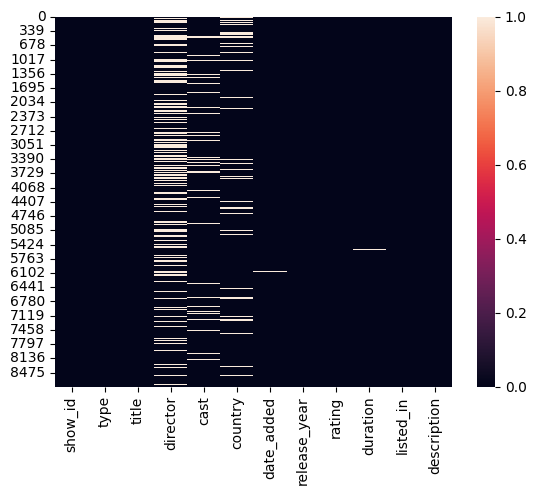

In [15]:
sns.heatmap(df_netflix.isnull())
plt.show()

A continuación nos detendremos un momento a estudiar el cado de las entradas del dataframe con valores NaN en las columnas **rating** y **duration**.

In [16]:
# Filtrar filas donde 'rating' es nulo
rating_nulos = df_netflix[df_netflix['rating'].isnull()]
rating_nulos

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5989,s5990,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"Oprah Winfrey, Ava DuVernay",NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
6827,s6828,TV Show,Gargantia on the Verdurous Planet,NaN,"Kaito Ishikawa, Hisako Kanemoto, Ai Kayano, Ka...",Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
7312,s7313,TV Show,Little Lunch,NaN,"Flynn Curry, Olivia Deeble, Madison Lu, Oisín ...",Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
7537,s7538,Movie,My Honor Was Loyalty,Alessandro Pepe,"Leone Frisa, Paolo Vaccarino, Francesco Miglio...",Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


En el caso de la columna **duration**, la duración se encuentra en la columna **rating**, sería esta última la que tiene valores perdidos.

In [17]:
# Filtrar filas donde 'duration' es nulo
duration_nulos = df_netflix[df_netflix['duration'].isnull()]
duration_nulos

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


Podemos confirmar que el catálogo incluye dos tipos de contenido distintos: películas y series. Además, hay hasta 17 clasificaciones de edad disponibles. 
En cuanto a la columna **country**, tenemos 748 valores distintos, recordamos que esta columna puede tener más de un país asociado por título, por eso el número tan elevado.

In [18]:
df_netflix.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

Por último, revisemos los resúmenes estadísticos de cada una de las variables o columnas. Se presentarán por separado los resúmenes de las variables numéricas y categóricas, simplemente por preferencia personal.

El año de lanzamiento promedio es 2014, con una desviación estándar de aproximadamente 8.82 años. Los títulos van desde 1925 hasta 2021, con el 25% de ellos lanzados antes de 2013, una mediana en 2017, y el 75% lanzado después de 2019.


In [19]:
# Variables numéricas

df_netflix.describe()

,release_year
count,8807.000000
mean,2014.180198
std,8.819312
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2019.000000
max,2021.000000


En cuanto a las variables categóricas podemos destacar que la frecuencia de aparición de ciertos valores como 'Movie' (6131 veces) hace destacar la predominancia de las películas en el DataFrame.

In [20]:
# Variables categóricas

df_netflix.describe(include = 'object')

,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,8807,8807,8807,6173,7982,7976,8797,8803,8804,8807,8807
unique,8807,2,8807,4528,7692,748,1767,17,220,514,8775
top,s1,Movie,Dick Johnson Is Dead,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2818,109,3207,1793,362,4


### 5.2 Amazon Prime DataSet

En este caso contamos con un dataframe de 12 columnas, como ya sabíamos, y 9668 entradas. El dataframe es mayor al de Netflix.

In [21]:
df_prime.shape

(9668, 12)

Volvemos a encontrarnos con una situación similar a la anterior, en la que, en este caso, las columnas country y date_added destacan por la gran cantidad de valores ausentes.

In [22]:
df_prime.sample(n = 10, random_state = 20)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
3983,s3984,Movie,Two Wrongs,Tristan Dubois,"Gillian Zinser, Aidan Devine, Ryan Blakely",NaN,NaN,2015,NaN,88 min,Suspense,Single mother Sarah struggles daily to balance...
6995,s6996,Movie,Six Weeks,Tony Bill,"Dudley Moore, Mary Tyler Moore, Katherine Heal...",NaN,NaN,1982,PG,108 min,Drama,"In this heart-warming drama, a terminally ill ..."
6560,s6561,Movie,Jacob's Hammer,Angie Bojtler,"Helen Holman, Luis James Farouk, Diane Rimmer,...",NaN,NaN,2016,13+,77 min,Horror,"The ultimate evil is in her son. Perhaps, the ..."
7836,s7837,TV Show,Rupi Kaur Live,NaN,Rupi Kaur,NaN,NaN,2021,TV-NR,1 Season,"Arts, Entertainment, and Culture",As a 21-year-old university student Rupi Kaur ...
6456,s6457,Movie,Ishtam,Prem Nizar,"Vimal, Nisha Aggarwal, Santhanam, Anoop Kumar,...",NaN,NaN,2012,13+,140 min,Romance,When three spirits possess a timid young man a...
5858,s5859,TV Show,Entitled,NaN,"Blake Rice, Gabriella Piazza, Patrick Daly, Tr...",NaN,NaN,2019,TV-MA,1 Season,"Comedy, Drama",After the sudden death of a pessimistic father...
705,s706,Movie,The Cowboy And The Senorita,Joseph Kane,"Roy Rogers, Dale Evans, Mary Lee, John Hubbard...",NaN,NaN,1944,13+,54 min,Western,A shady gambler attempts to snatch the rights ...
8439,s8440,Movie,Future Fear,Ken May,"Kaylith Von Kola, Otis Johnson, Raven Ebner, R...",NaN,NaN,2021,16+,93 min,"Action, Science Fiction","In a distant future, an archeologist on the ru..."
4264,s4265,Movie,Yuvarathnaa (Telugu),Santhosh Ananddram,"Puneeth Rajkumar, Sayyeshaa Saigal, Prakash Ra...",NaN,NaN,2021,NR,159 min,"Action, Drama, Kids","YUVARATHNAA, revolves around RK University (Go..."
4093,s4094,Movie,Mummy Dearest,White Cross,"Tara Reid, Michael Paré, Lou Ferrigno, Richard...",NaN,NaN,2018,16+,95 min,"Horror, Suspense",After an injury puts Scarlett Healy in a wheel...


Esa ausencia de valores queda confirada a continuación, siendo las columnas con menos entradas.

In [23]:
df_prime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7585 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB


In [24]:
df_prime.isnull().sum()

show_id            0
type               0
title              0
director        2083
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
dtype: int64

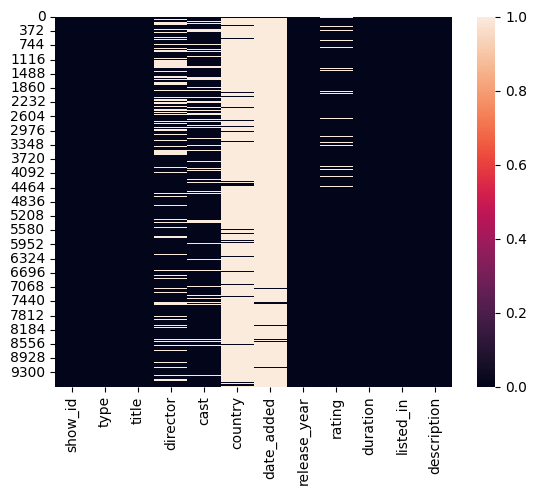

In [25]:
sns.heatmap(df_prime.isnull())
plt.show()

Como pasaba con el dataframe de Netflix, aquí tenemos dos valores para el tipo de contenido. En este caso tenemos hasta 24 clasificaciones por edad distintas.

In [26]:
df_prime.nunique()

show_id         9668
type               2
title           9668
director        5773
cast            7927
country           86
date_added        84
release_year     100
rating            24
duration         219
listed_in        518
description     9414
dtype: int64

De Prime Video tenemos contenido desde 1920 hasta 2021. La mayoría de los títulos están concentrados en los últimos años, con una media en 2008.

In [27]:
# Variables numéricas
df_prime.describe()

,release_year
count,9668.000000
mean,2008.341849
std,18.922482
min,1920.000000
25%,2007.000000
50%,2016.000000
75%,2019.000000
max,2021.000000


In [28]:
# Variables categóricas
df_prime.describe(include = 'object')

,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,9668,9668,9668,7585,8435,672,155,9331,9668,9668,9668
unique,9668,2,9668,5773,7927,86,84,24,219,518,9414
top,s1,Movie,The Grand Seduction,Mark Knight,Maggie Binkley,United States,"March 30, 2021",13+,1 Season,Drama,"Arpo was designed as a commando robot, built a..."
freq,1,7814,1,113,56,253,14,2117,1342,986,15


### 5.3 Metodología a Seguir tras la Exploración Inicial

Tras esta exploración de los datos, y con el objetivo de concatenar los dos dataframes, los pasos a seguir en el apartado de limpieza y transformación se dividirán en dos etapas:

- **Etapa 1 - Antes de la unión** 
    - Añadir la columna **plataforma** a cada dataframe para especificar a qué plataforma de streaming pertenece cada título.
    - Modificar los valores de **show_id**: si un título es de Netflix, se añadirá una "N" al comienzo del identificador; en caso contrario, se añadirá una "P".
    - Corregir los tres valores intercambiados entre las columnas **rating** y **duration** en el dataframe de Netflix.
- **Etapa 2 - Después de la unión**
    - Eliminar las entradas con valores NaN en la columna **rating**.
    - Separar la columna **duration** en dos columnas: una para el valor de la duración y otra para la unidad de tiempo (Season o min).
    - Reemplazar los valores NaN en **year_added** con valores predeterminados adecuados.
    - Reemplazar los valores NaN en las columnas **director**, **cast**, **country**, y **listed_in** por ``Sin especificar``.

## 6. Limpieza y Preparación de Datos

### 6.1 Etapa 1

Comenzamos corrigiendo los tres valores intercambiados entre las columnas **rating** y **duration** en el dataframe de Netflix (df_netflix).

In [29]:
# Identificar las filas donde 'duration' es NaN y 'rating' contiene la palabra min
condicion = df_netflix['duration'].isnull() & df_netflix['rating'].str.contains('min', na=False)

# Mover los valores de 'rating' a 'duration'
df_netflix.loc[condicion, 'duration'] = df_netflix.loc[condicion, 'rating']

# Establecer los valores de 'rating' en esas filas
df_netflix.loc[condicion, 'rating'] = "R"



En este caso, tras investigar un poco, como las tres entradas pertenecen a un comediante, en lugar de dejar el **rating** como NaN, se ha cambiado a 'R' (restricted).

In [30]:
df_netflix.loc[df_netflix['director'] == 'Louis C.K.']

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,R,74 min,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,R,84 min,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,R,66 min,Movies,The comic puts his trademark hilarious/thought...


Continuamos añadiendo el prefijo 'N' al **show_id** de Netflix.

In [31]:
df_netflix['show_id'] = df_netflix['show_id'].apply(lambda x: x if x.startswith('N') else 'N' + x)
df_netflix["plataforma"] = "Netflix"
df_netflix.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma
0,Ns1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",Netflix
1,Ns2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",Netflix
2,Ns3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Netflix
3,Ns4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",Netflix
4,Ns5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,Netflix


Y el prefijo 'P' al contenido de Prime Video.

In [32]:
df_prime['show_id'] = df_prime['show_id'].apply(lambda x: x if x.startswith('P') else 'P' + x)
df_prime["plataforma"] = "Prime"
df_prime.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma
0,Ps1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...,Prime
1,Ps2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...,Prime
2,Ps3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...,Prime
3,Ps4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ...",Prime
4,Ps5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...,Prime


Por último uniremos los dos dataframes, que en este caso no es una unión sino una concatenación de las filas. Para ello usaremos ***concat()***

In [33]:
df_combined = pd.concat([df_netflix, df_prime], ignore_index=True)
df_combined.sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma
1883,Ns1884,Movie,StarBeam: Halloween Hero,Jon Izen,"Nahanni Mitchell, Dean Petriw, Terry Klassen, ...",Canada,"October 6, 2020",2020,TV-Y,33 min,Children & Family Movies,Greedy Captain Fishbeard is stealing everybody...,Netflix
4886,Ns4887,Movie,CIA: Comrade in America,Amal Neerad,"Dulquer Salmaan, Karthika Muraleedharan, Siddi...",India,"May 1, 2018",2017,TV-14,130 min,"Action & Adventure, Dramas, Independent Movies",A young man in Kerala has two weeks to stop th...,Netflix
13611,Ps4805,Movie,Love and Friendship,Whit Stillman,"Kate Beckinsale, Chloe Sevigny, Xavier Samuel,...",NaN,NaN,2016,PG,94 min,"Drama, Historical","Set in 1790s London, LOVE AND FRIENDSHIP cente...",Prime
2221,Ns2222,Movie,Jack Whitehall: I'm Only Joking,"Dave Skinner, Freddie Waters",Jack Whitehall,United Kingdom,"July 21, 2020",2020,TV-MA,58 min,Stand-Up Comedy,Jack Whitehall hits the stage with hilarious t...,Netflix
3562,Ns3563,TV Show,HERO MASK,NaN,"Yasuyuki Kase, Yuhko Kaida, Junpei Morita, Ken...",NaN,"August 23, 2019",2019,TV-14,2 Seasons,"Anime Series, Crime TV Shows, International TV...","After a rash of mysterious deaths, Crown prose...",Netflix
12330,Ps3524,Movie,15-Minute Strength & Sculpt 4.0 Workout,NaN,Maggie Binkley,NaN,NaN,2017,ALL,17 min,Fitness,"No equipment needed. Tip: Complete Series 1.0,...",Prime
3147,Ns3148,Movie,Talaash,Reema Kagti,"Aamir Khan, Rani Mukerji, Kareena Kapoor, Nawa...",India,"December 15, 2019",2012,TV-14,140 min,"Dramas, International Movies, Thrillers","Set in the jumbled landscape of Mumbai, this m...",Netflix
17050,Ps8244,Movie,The Omen,NaN,"Liev Schreiber, Julia Stiles, Mia Farrow, Sara...",NaN,NaN,2006,R,110 min,"Drama, Horror, Suspense",When the U.S. ambassador to England begins to ...,Prime
1492,Ns1493,TV Show,Bridgerton,NaN,"Adjoa Andoh, Julie Andrews, Lorraine Ashbourne...",United States,"December 25, 2020",2020,TV-MA,1 Season,"Romantic TV Shows, TV Dramas",The eight close-knit siblings of the Bridgerto...,Netflix
12249,Ps3443,TV Show,99 Days With the Superstar,NaN,"Hidetoshi Nishijima, Jun Kaname, Kim Tae-hee, ...",NaN,NaN,2011,13+,1 Season,"Comedy, Romance",A quiet Japanese security guard's humble life ...,Prime


Ahora tenemos un único dataframe con 13 columnas y 18475 entradas.

In [34]:
df_combined.shape

(18475, 13)

Comprobemos las columnas con valores NaN que tenemos que transformar.

In [35]:
df_combined.isnull().sum()

show_id            0
type               0
title              0
director        4717
cast            2058
country         9827
date_added      9523
release_year       0
rating           341
duration           0
listed_in          0
description        0
plataforma         0
dtype: int64

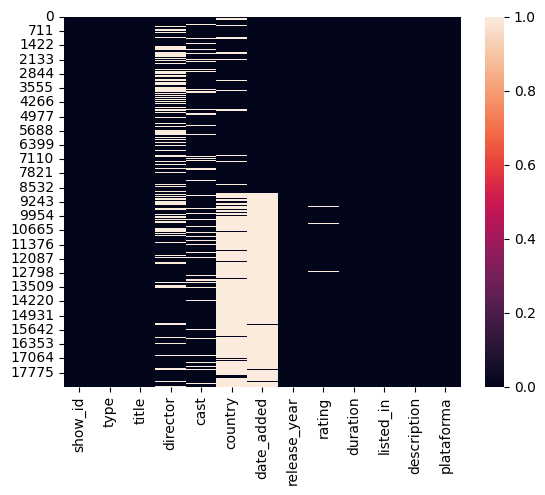

In [36]:
sns.heatmap(df_combined.isnull())
plt.show()

### 6.2 Etapa 2

Si estudiamos la proporción que representan los valores NaN en las columnas **director**, **cast**, **country**, y **rating** respecto al total de entradas de nuestro dataframe, podemos apreciar que, si elimináramos los valores NaN de la columna **country**, estaríamos perdiendo más de la mitad del dataframe (53%). Estas entradas, aunque no tengan el país de producción, pueden contener otra información relevante para el estudio. Por tanto, eliminarlas no es una opción. Tampoco podemos sustituir esos valores por el valor modal de esa columna, ya que el resultado podría no ser coherente. No queda otra opción que reemplazar los valores NaN por `Sin especificar`. Con las columnas **director** y **cast**, aunque el porcentaje de valores NaN es mucho menor, se aplicará la misma solución.

En cuanto a la columna **rating**, los valores NaN solo representan el 1.8% de las filas del dataframe. Aunque se podría aplicar el mismo tratamiento, con el propósito de utilizar una mayor variedad de técnicas, se optará por eliminarlos.

In [37]:
calcular_proporcion_nulos(df_combined, 'director', 'cast', 'country', 'rating')

{'director': 0.2553179972936401,
 'cast': 0.1113937753721245,
 'country': 0.5319079837618403,
 'rating': 0.018457374830852503}

In [38]:
# Eliminar las filas donde 'rating' es NaN
df_combined = df_combined.dropna(subset=['rating'])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18134 entries, 0 to 18474
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       18134 non-null  object
 1   type          18134 non-null  object
 2   title         18134 non-null  object
 3   director      13427 non-null  object
 4   cast          16101 non-null  object
 5   country       8630 non-null   object
 6   date_added    8933 non-null   object
 7   release_year  18134 non-null  int64 
 8   rating        18134 non-null  object
 9   duration      18134 non-null  object
 10  listed_in     18134 non-null  object
 11  description   18134 non-null  object
 12  plataforma    18134 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.9+ MB


Continuando con la columna **rating**, tenemos varios valores para representar la misma información, es decir para un contenido con una clasificación por edad para mayores de 16 años tenemos las categorías: `16`, `16+` y `AGES_16_`. 

In [39]:
# Obtener valores únicos de la columna 'rating' excluyendo NaN
valores_unicos_rating = df_combined['rating'].dropna().unique()
valores_unicos_rating

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', 'TV-Y7-FV', 'UR', '13+', 'ALL', '18+',
       '16+', '7+', 'TV-NR', 'UNRATED', '16', 'AGES_16_', 'AGES_18_',
       'ALL_AGES', 'NOT_RATE'], dtype=object)

Vamos a agrupar estas clasificaciones en menos categorías.

In [40]:
df_combined['edad_categoria'] = df_combined['rating'].apply(categorizar_rating)
df_combined.sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma,edad_categoria
10963,Ps2157,Movie,I Am Road Comic,Jordan Brady,"Maria Bamford, Marc Maron, Doug Benson, Alonzo...",NaN,NaN,2014,18+,68 min,"Arts, Entertainment, and Culture, Comedy, Spec...",People are fascinated more than ever about wha...,Prime,18+
13770,Ps4964,Movie,Toys Storage 2,"Christine Arnold, Conor Reed, Brian Watson, Ch...","Marianna Novak, Dante White Aliano, Todd Warin...",NaN,NaN,2021,13+,99 min,"Animation, Kids",Don't Lose Heart is the story about a young gi...,Prime,13+
6295,Ns6296,TV Show,Bhaage Re Mann,NaN,"Karuna Pandey, Chandan Anand, Kanika Shivpuri,...",India,"April 15, 2017",2015,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...","An impulsive, free-spirited woman who's defied...",Netflix,13+
10092,Ps1286,TV Show,Police Rescue,NaN,"Gary Sweet, Sonia Todd, Steve Bastoni, John Cl...",NaN,NaN,1991,16+,1 Season,"Action, Drama","When you work on the Police Rescue squad, trou...",Prime,16+
7944,Ns7945,Movie,Satte Pe Satta,Raj N. Sippy,"Amitabh Bachchan, Hema Malini, Amjad Khan, Sac...",India,"December 31, 2019",1982,TV-14,153 min,"Comedies, Cult Movies, Dramas",The eldest of seven brothers who run a family ...,Netflix,13+
5039,Ns5040,Movie,Chris Rock: Tamborine,Bo Burnham,Chris Rock,United States,"February 14, 2018",2018,TV-MA,65 min,Stand-Up Comedy,Chris Rock takes the stage in Brooklyn for a c...,Netflix,18+
15377,Ps6571,Movie,Her Name Was Christa,James L. Edwards,"Shianne Daye, James L. Edwards, Drew Fortier, ...",NaN,NaN,2020,18+,120 min,"Horror, Romance","Stephen is a socially awkward, desperately alo...",Prime,18+
18195,Ps9389,Movie,Criminal Mind,Joseph Vittorie,"Frank Rossi, Tahnee Welch, Lance Henriksen",NaN,NaN,1993,R,92 min,Suspense,A young District Attorney pays a visit to his ...,Prime,18+
9732,Ps926,Movie,Spiral,Laura Fairrie,NaN,NaN,NaN,2017,13+,78 min,Special Interest,"SPIRAL is the story of how a cycle of fear, ha...",Prime,13+
578,Ns579,Movie,Memoirs of a Geisha,Rob Marshall,"Zhang Ziyi, Ken Watanabe, Koji Yakusho, Michel...","France, Japan, United States","July 1, 2021",2005,PG-13,145 min,"Dramas, Romantic Movies","Sold to a geisha house as a child, a fisherman...",Netflix,13+


Ahora toca encargarse del campo **date_added**. Para empezar, se creará otra columna, **date**, que contendrá la cadena de **date_added** en formato datetime. Además, se crearán tres columnas adicionales: **year**, **month** y **day**, con los respectivos datos de la fecha.

In [41]:
# Limpiar espacios adicionales
df_combined['date'] = df_combined['date_added'].str.strip()

# Intentar convertir las fechas
df_combined['date'] = pd.to_datetime(df_combined['date'], format='%B %d, %Y')


df_combined['year'] = df_combined['date'].dt.year
df_combined['year'] = df_combined['year'].fillna(0).astype(int)

df_combined['month'] = df_combined['date'].dt.month
df_combined['month'] = df_combined['month'].fillna(0).astype(int)

df_combined['day'] = df_combined['date'].dt.day
df_combined['day'] = df_combined['day'].fillna(0).astype(int)

df_combined.sample(5)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma,edad_categoria,date,year,month,day
17163,Ps8357,Movie,Unfollower,Julie Crisante,"Dan Davidson, Marty Lindsey",NaN,NaN,2021,16+,91 min,Suspense,When a self-conscious fitness instructor named...,Prime,16+,NaT,0,0,0
2044,Ns2045,TV Show,Away,NaN,"Hilary Swank, Josh Charles, Vivian Wu, Mark Iv...",United States,"September 4, 2020",2020,TV-14,1 Season,"Romantic TV Shows, TV Dramas, TV Sci-Fi & Fantasy",Commander Emma Green leaves behind her husband...,Netflix,13+,2020-09-04,2020,9,4
18404,Ps9598,Movie,Gold Digger,Ville Jankeri,"Minka Kuustonen, Olavi Uusivirta, Pamela Tola,...",NaN,NaN,2016,18+,82 min,Comedy,A financially struggling fashion influencer me...,Prime,18+,NaT,0,0,0
17939,Ps9133,Movie,Once Upon A Time In Mexico,Robert Rodriguez,"Antonio Banderas, Salma Hayek, Johnny Depp, Mi...","United States, Mexico",NaN,2003,R,102 min,"Action, Adventure, Drama",Returning from exile to avenge his slain famil...,Prime,18+,NaT,0,0,0
8457,Ns8458,Movie,The Pirates! Band of Misfits,"Peter Lord, Jeff Newitt","Hugh Grant, Martin Freeman, Imelda Staunton, D...","United Kingdom, United States","October 1, 2020",2012,PG,88 min,"Children & Family Movies, Comedies",An egotistical pirate captain strives to win t...,Netflix,0+,2020-10-01,2020,10,1


En este caso, la solución que se plantea, sobre todo por tratarse de un proyecto académico, es completar los años faltantes, ya que sabemos en qué año fue lanzado cada uno de los títulos y podemos especificar en qué año comenzaron a operar estas plataformas de streaming. Podemos generar esta fecha de forma aleatoria; no será la fecha verdadera, pero al menos será coherente. Es decir, no veremos un título lanzado en 2021 añadido a ninguna de las plataformas en 2019. 

In [42]:
# Usamos la función fill_nan_dates 
df_combined = df_combined.apply(fill_nan_dates, axis=1)

df_combined.sample(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma,edad_categoria,date,year,month,day
4094,Ns4095,Movie,Genius,Suseenthiran,"Roshan, Priyaa Lal, Aadukalam Naren, Singam Pu...",India,"February 17, 2019",2018,TV-14,96 min,"Dramas, Independent Movies, International Movies",Extreme pressure from his father to excel at s...,Netflix,13+,2019-02-17,2019,2,17
6085,Ns6086,Movie,Across the Universe,Julie Taymor,"Evan Rachel Wood, Jim Sturgess, Joe Anderson, ...","United States, United Kingdom","January 1, 2019",2007,PG-13,133 min,"Dramas, Music & Musicals, Romantic Movies",An American girl and a British lad fall in lov...,Netflix,13+,2019-01-01,2019,1,1
1304,Ns1305,Movie,Animals on the Loose: A You vs. Wild Movie,Ben Simms,Bear Grylls,United States,"February 16, 2021",2021,TV-PG,139 min,Children & Family Movies,"When wild animals escape from a sanctuary, Bea...",Netflix,0+,2021-02-16,2021,2,16
764,Ns765,Movie,Trippin' with the Kandasamys,Jayan Moodley,"Jailoshini Naidoo, Maeshni Naicker, Madhushan ...",South Africa,"June 4, 2021",2021,TV-14,94 min,"Comedies, International Movies, Romantic Movies","To rekindle their marriages, best friends-turn...",Netflix,13+,2021-06-04,2021,6,4
5722,Ns5723,TV Show,Case,NaN,"Steinunn Ólína Þorsteinsdóttir, Magnús Jónsson...",Iceland,"November 9, 2016",2015,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas",A smart lawyer whose drinking and recklessness...,Netflix,18+,2016-11-09,2016,11,9
3824,Ns3825,TV Show,I Hear You,NaN,"Riley Wang, Zhao Lusi, Zhang Jiongmin, Gratitu...",NaN,"May 15, 2019",2019,TV-14,1 Season,"International TV Shows, Romantic TV Shows, TV ...","Love blooms between a bubbly, aspiring voice a...",Netflix,13+,2019-05-15,2019,5,15
17834,Ps9028,Movie,Blunderpuss,Shaina Feinberg,"Chris Manley, Jeff Seal, Drae Campbell, Karole...",NaN,NaN,2021,16+,74 min,Comedy,Mike Bruton is a clown with a drinking problem...,Prime,16+,NaT,2021,5,3
17890,Ps9084,TV Show,The Alchemists,NaN,"Grant Show, Ruth Gemmell, Edward Hardwicke",NaN,NaN,1999,TV-14,1 Season,"Drama, Suspense",A fast-paced thriller based on Peter James' be...,Prime,13+,NaT,2016,5,3
11842,Ps3036,TV Show,Blippi - Videos for Kids,NaN,Stevin John,NaN,NaN,2016,ALL,1 Season,"Kids, Special Interest",Blippi in this educational series for toddlers...,Prime,0+,NaT,2016,5,3
18376,Ps9570,Movie,Under the Greenwood Tree,Nick Laughland,"James Murray, Steve Pemberton, Keeley Hawes, B...",NaN,NaN,2005,7+,94 min,"Drama, Romance",Amidst the surrounding farms and woodlands of ...,Prime,7+,NaT,2016,5,3


Para terminar con las fechas, actualizaremos los valores NaT de la columna **date** a partir de los generados anteriormente para **year**, **month** y **day**

In [43]:
# Crear una condición para identificar filas con valores nulos en 'date'
missing_date_mask = df_combined['date'].isna()

# Rellenar la columna 'date' solo para las filas con valores nulos
df_combined.loc[missing_date_mask, 'date'] = pd.to_datetime(df_combined.loc[missing_date_mask, ['year', 'month', 'day']])

df_combined.sample(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,plataforma,edad_categoria,date,year,month,day
3538,Ns3539,Movie,Elena,Petra Costa,NaN,"Brazil, United States","September 1, 2019",2012,TV-MA,81 min,"Documentaries, International Movies","In this documentary, the director remembers a ...",Netflix,18+,2019-09-01,2019,9,1
9147,Ps341,Movie,Ticker,Albert Pyun,"Tom Sizemore, Dennis Hopper, Steven Seagal",United States,NaN,2001,R,92 min,"Action, Adventure, Suspense",When a mad bomber (Dennis Hopper) descends on ...,Prime,18+,2016-05-03,2016,5,3
8196,Ns8197,Movie,The Art of War,Christian Duguay,"Wesley Snipes, Anne Archer, Maury Chaykin, Mar...","United States, Canada","July 1, 2020",2000,R,117 min,Action & Adventure,"Framed for the murder of an ambassador, a form...",Netflix,18+,2020-07-01,2020,7,1
3860,Ns3861,TV Show,Crime Diaries: Night Out,Felipe Cano,"Sebastián Osorio, Fabiana Medina, Laura Osma, ...",Mexico,"May 3, 2019",2019,TV-MA,1 Season,"Crime TV Shows, International TV Shows, Spanis...","After going to a Halloween party, college stud...",Netflix,18+,2019-05-03,2019,5,3
9943,Ps1137,Movie,Romance On The Range,Joseph Kane,"Roy Rogers, George ""Gabby"" Hayes, Linda Hayes,...",NaN,NaN,1942,13+,53 min,"Suspense, Western","Roy Rogers, the owner of a western ranch, susp...",Prime,13+,2016-05-03,2016,5,3


Y eliminamos la columna **date_added**

In [44]:
df_combined = df_combined.drop('date_added', axis=1)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18134 entries, 0 to 18474
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   show_id         18134 non-null  object        
 1   type            18134 non-null  object        
 2   title           18134 non-null  object        
 3   director        13427 non-null  object        
 4   cast            16101 non-null  object        
 5   country         8630 non-null   object        
 6   release_year    18134 non-null  int64         
 7   rating          18134 non-null  object        
 8   duration        18134 non-null  object        
 9   listed_in       18134 non-null  object        
 10  description     18134 non-null  object        
 11  plataforma      18134 non-null  object        
 12  edad_categoria  18134 non-null  object        
 13  date            18134 non-null  datetime64[ns]
 14  year            18134 non-null  int64         
 15  month  

In [45]:
df_combined.isnull().sum()

show_id              0
type                 0
title                0
director          4707
cast              2033
country           9504
release_year         0
rating               0
duration             0
listed_in            0
description          0
plataforma           0
edad_categoria       0
date                 0
year                 0
month                0
day                  0
dtype: int64

Continuamos con el campo **duration**. Se crearán dos columnas, **duration_value** y **duration_unit**, y se separará la información de duration en estas dos.

In [46]:
df_combined[['duration_value', 'duration_unit']] = df_combined['duration'].str.split(expand=True)

# Convertir la columna 'number' a tipo float si es necesario
df_combined['duration_value'] = df_combined['duration_value'].astype(int)

df_combined.sample(5)

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,plataforma,edad_categoria,date,year,month,day,duration_value,duration_unit
7659,Ns7660,Movie,Once Upon a Time in the West,Sergio Leone,"Henry Fonda, Charles Bronson, Claudia Cardinal...","Italy, United States",1968,PG-13,166 min,"Action & Adventure, Classic Movies, Internatio...","In this epic spaghetti Western, a flinty gunsl...",Netflix,13+,2019-11-20,2019,11,20,166,min
10690,Ps1884,TV Show,Legend of Fuyao,NaN,"Yang Mi, Ethan Juan, Zhang Dongshen, Hu Ke",NaN,2018,18+,1 Season,"Drama, Romance",Meng Fuyao is a master of the invincible Po Ji...,Prime,18+,2018-05-03,2018,5,3,1,Season
2007,Ns2008,Movie,Dad Wanted,Javier Colinas,"Natalia Coronado, Juan Pablo Medina, Silvia Na...",Mexico,2020,TV-14,103 min,"Children & Family Movies, Comedies, Dramas",What does a thrill-seeker tween girl do when h...,Netflix,13+,2020-09-11,2020,9,11,103,min
12548,Ps3742,Movie,The Girl King,Mika Kaurismäki,"Malin Buska, Sarah Gadon, Michael Nyqvist",NaN,2015,18+,106 min,"Drama, LGBTQ, Romance","""The Girl King"" paints a portrait of the brill...",Prime,18+,2016-05-03,2016,5,3,106,min
7788,Ns7789,Movie,Power Rangers: Megaforce: The Robo Knight Befo...,James Barr,"Andrew M. Gray, Ciara Hanna, John Mark Louderm...",United States,2013,TV-Y7,24 min,Children & Family Movies,Robo Knight learns the meaning of Christmas fr...,Netflix,7+,2016-01-01,2016,1,1,24,min


Solamente nos queda reemplazar los valores NaN por un `Sin especificar`.

In [47]:
df_combined.isnull().sum()

show_id              0
type                 0
title                0
director          4707
cast              2033
country           9504
release_year         0
rating               0
duration             0
listed_in            0
description          0
plataforma           0
edad_categoria       0
date                 0
year                 0
month                0
day                  0
duration_value       0
duration_unit        0
dtype: int64

In [48]:
df_final = df_combined.fillna({columna: 'Sin especificar' for columna in ['director', 'cast', 'country']})
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18134 entries, 0 to 18474
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   show_id         18134 non-null  object        
 1   type            18134 non-null  object        
 2   title           18134 non-null  object        
 3   director        18134 non-null  object        
 4   cast            18134 non-null  object        
 5   country         18134 non-null  object        
 6   release_year    18134 non-null  int64         
 7   rating          18134 non-null  object        
 8   duration        18134 non-null  object        
 9   listed_in       18134 non-null  object        
 10  description     18134 non-null  object        
 11  plataforma      18134 non-null  object        
 12  edad_categoria  18134 non-null  object        
 13  date            18134 non-null  datetime64[ns]
 14  year            18134 non-null  int64         
 15  month  

In [49]:
df_final.sample(5)

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description,plataforma,edad_categoria,date,year,month,day,duration_value,duration_unit
8269,Ns8270,Movie,The Daughter,Simon Stone,"Geoffrey Rush, Ewen Leslie, Paul Schneider, Mi...",Australia,2015,TV-MA,95 min,Dramas,Having returned home for his cagey father's we...,Netflix,18+,2017-04-26,2017,4,26,95,min
3936,Ns3937,TV Show,Derek,Sin especificar,"Ricky Gervais, Kerry Godliman, Karl Pilkington...",United Kingdom,2015,TV-MA,3 Seasons,"British TV Shows, International TV Shows, TV C...",Ricky Gervais created and stars in this heartw...,Netflix,18+,2019-04-05,2019,4,5,3,Seasons
15315,Ps6509,Movie,Thom & Dusty Go To Mexico,Thom Marshall,"Victor Tomasino, John Lee Ames, Eloy Mendez, S...",Sin especificar,2015,13+,83 min,Comedy,An Action packed comedy of two regular guys wh...,Prime,13+,2016-05-03,2016,5,3,83,min
2766,Ns2767,Movie,Maska,Neeraj Udhwani,"Manisha Koirala, Prit Kamani, Shirley Setia, N...",India,2020,TV-MA,112 min,"Comedies, Dramas, International Movies","Determined to make it in showbiz, an aspiring ...",Netflix,18+,2020-03-27,2020,3,27,112,min
8774,Ns8775,Movie,يوم الدين,Abu Bakr Shawky,"Rady Gamal, Ahmed Abdelhafiz, Shahira Fahmy, S...","Egypt, Austria, United States",2018,TV-14,97 min,"Dramas, Independent Movies, International Movies",A man cured of leprosy and a young orphan leav...,Netflix,13+,2019-10-22,2019,10,22,97,min


## 7. Visualización de los datos

In [50]:
PALETA = {'Netflix': '#B1060F', 'Prime': '#18254F'}
NETFLIX = ['#B1060F', '#1F1F1F']
PRIME = ['#3D8DC4', '#18254F']

### Número de Títulos por Plataforma

La siguiente gráfica de barras horizontales compara el número de contenidos disponibles entre "Prime" y "Netflix", mostrando que ambas plataformas tienen un número similar de contenidos.

C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\505266695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


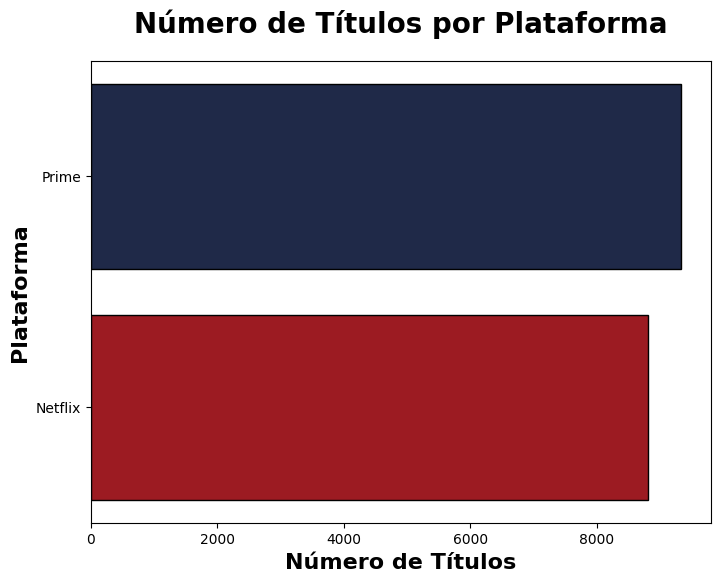

In [51]:
plt.figure(figsize=(8, 6))
content_counts = df_final['plataforma'].value_counts().sort_values(ascending=False)

sns.barplot(
    x=content_counts.values, 
    y=content_counts.index, 
    palette= PALETA, 
    edgecolor='black', 
    linewidth=1
)
plt.title('Número de Títulos por Plataforma', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Número de Títulos', fontsize=16, fontweight='bold')
plt.ylabel('Plataforma', fontsize=16, fontweight='bold')
plt.show()


### Distribución de Títulos por Tipo de Contenido y Plataforma

Tanto Netflix como Prime Video tienen más contenido en la categoría de "Movie" que en "TV Show". Prime Video tiene un mayor número de películas que Netflix, pero Netflix tiene más programas de TV que Prime.

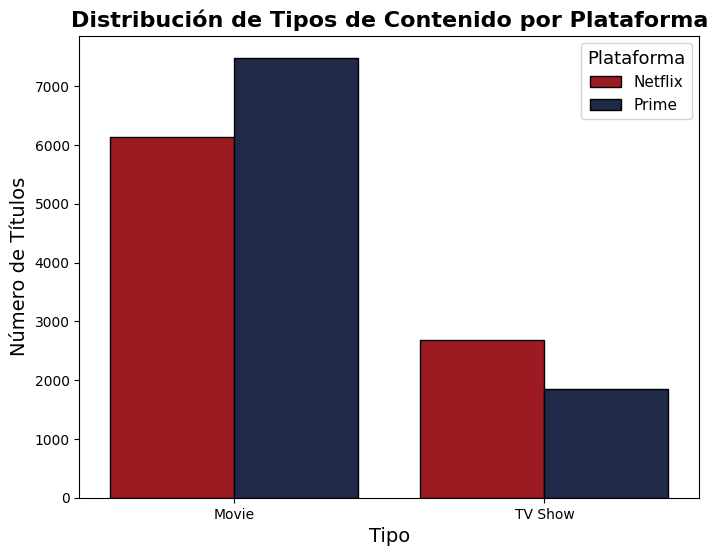

In [52]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_final, x='type', hue='plataforma', palette= PALETA, edgecolor='Black')

plt.title('Distribución de Tipos de Contenido por Plataforma', fontsize=16, fontweight='bold')
plt.xlabel('Tipo', fontsize=14)
plt.ylabel('Número de Títulos', fontsize=14)
plt.legend(title='Plataforma', title_fontsize='13', fontsize='11')
plt.show()


### Distribución de Tipos de Contenido por Plataforma (Pie Chart)

Trasladando esto a porcentajes. La proporción de películas en Prime (80.2%) es mayor que en Netflix (69.6%), mientras que Netflix tiene una mayor proporción de programas de TV (30.4%) en comparación con Prime (19.8%).

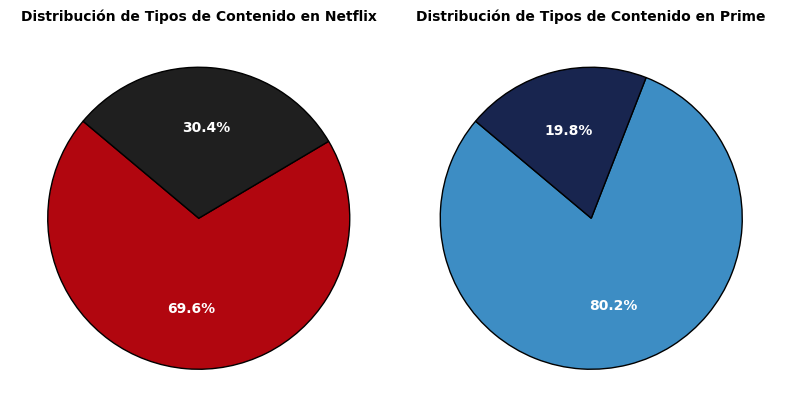

In [53]:
# Calcular la distribución de tipos de contenido por plataforma
type_counts_netflix = df_final[df_final['plataforma'] == 'Netflix']['type'].value_counts()
type_counts_prime = df_final[df_final['plataforma'] == 'Prime']['type'].value_counts()

# Crear la figura con dos gráficos de sectores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Diagrama de sectores para Netflix
ax1.pie(
    type_counts_netflix, 
    labels=type_counts_netflix.index, 
    autopct='%1.1f%%', 
    colors = NETFLIX,  # Colores específicos para Netflix
    startangle=140, 
    wedgeprops={'edgecolor': 'black'},
    textprops={'color': 'white', 'fontweight': 'bold'}
)
ax1.set_title('Distribución de Tipos de Contenido en Netflix', fontsize=10, fontweight='bold')

# Diagrama de sectores para Prime
ax2.pie(
    type_counts_prime, 
    labels=type_counts_prime.index, 
    autopct='%1.1f%%', 
    colors = PRIME,  # Colores específicos para Prime
    startangle=140, 
    wedgeprops={'edgecolor': 'black'},
    textprops={'color': 'white', 'fontweight': 'bold'}
)
ax2.set_title('Distribución de Tipos de Contenido en Prime', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### Número de Títulos Añadidos a Ambas Plataformas por año

Hay un pico significativo con más de 5000 títulos añadidos, lo que representa el mayor número de títulos agregados en el periodo mostrado. A partir de 2017, el número de títulos disminuye, pero se mantiene en una cantidad considerable, alrededor de 1500 a 3000 títulos por año.

C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\418332404.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


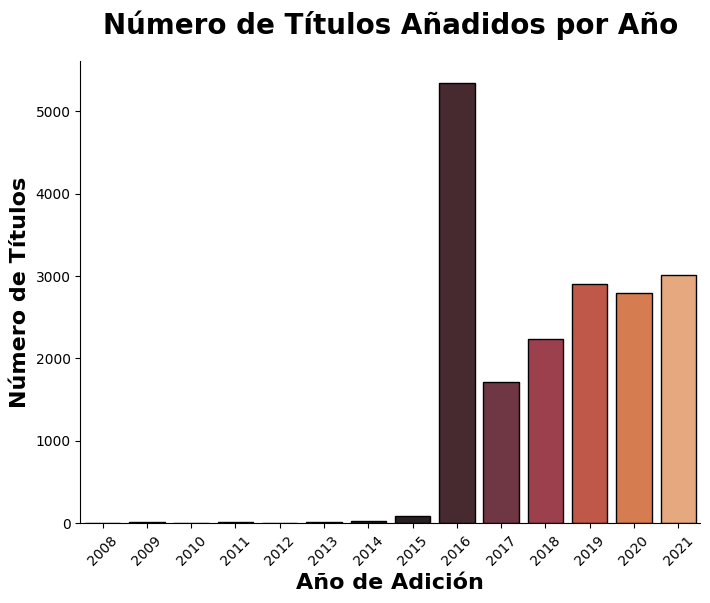

In [54]:
plt.figure(figsize=(8, 6))

# Contar el número de títulos por año
content_per_year = df_final['year'].value_counts().sort_index()


sns.barplot(
    x=content_per_year.index, 
    y=content_per_year.values, 
    palette= "icefire", 
    edgecolor='black'
)

plt.title('Número de Títulos Añadidos por Año', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Año de Adición', fontsize=16, fontweight='bold')
plt.ylabel('Número de Títulos', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)

sns.despine() # Elimina los líneas superior y derecho del gráfico

plt.show()


### Número de Títulos Añadidos Año y por Plataforma

Prime tuvo un gran impulso en 2016, añadiendo una cantidad masiva de títulos, pero luego Netflix tomó el liderazgo en los años siguientes con un flujo constante de títulos agregados. Ambas plataformas experimentaron un crecimiento significativo en los años posteriores a 2016, pero Prime parece tener un ritmo más moderado comparado con Netflix en los últimos años.

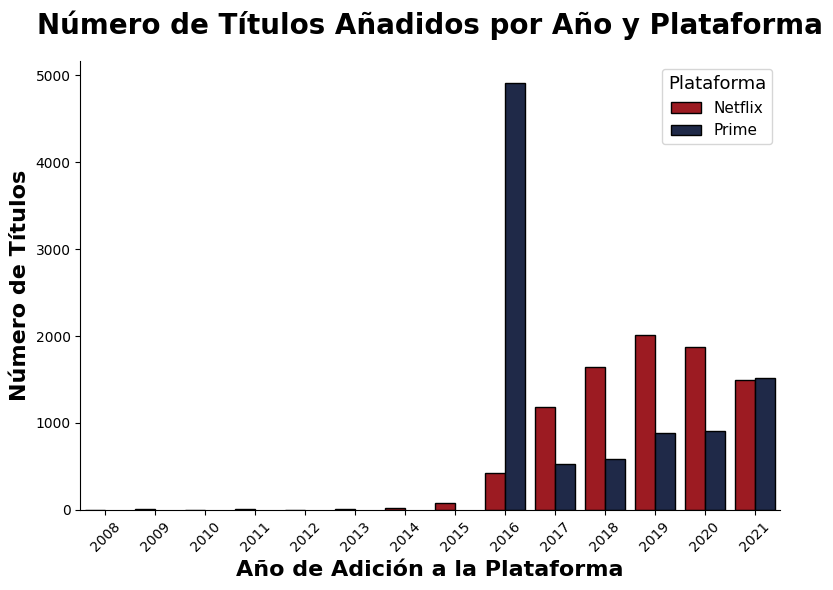

In [55]:
plt.figure(figsize=(8, 6))

# Agrupar los datos por año y plataforma 
content_per_year_platform = df_final.groupby(['year', 'plataforma']).size().reset_index(name='counts')

 
sns.barplot(
    data=content_per_year_platform, 
    x='year', 
    y='counts', 
    hue='plataforma',  
    palette=PALETA, 
    edgecolor='black'
)


plt.title('Número de Títulos Añadidos por Año y Plataforma', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Año de Adición a la Plataforma', fontsize=16, fontweight='bold')
plt.ylabel('Número de Títulos', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Plataforma', title_fontsize='13', fontsize='11')
sns.despine()
plt.tight_layout()


plt.show()


### Relevancia de los Géneros de Ambas Plataformas (WordCloud)

A continuación vamos a generar una nube de palabras, en ella los tamaños de las palabras representan su frecuencia o relevancia en nuestro conjunto de datos.
Por tanto, las palabras más grandes (más frecuentes o relevantes) son los géneros más comunes o destacados, entre ellos apreciamos: Show, Movies, Action, Adventure, Comedy, Fantasy, Horror, Anime y Drama.

In [56]:
df_listed_in = pd.DataFrame()

df_listed_in = df_final['listed_in'].str.split(',', expand = True).stack()
df_listed_in = df_listed_in.to_frame()
df_listed_in.columns = ['listed_in']

df_listed_in['listed_in'] = df_listed_in['listed_in'].str.strip().str.title()
# Crear un diccionario de mapeo para unificar categorías
category_mapping = {
    'Dramas': 'Drama',
    'Comedies': 'Comedy', 
    'Documentaries': 'Documentary'
}

# Aplicar el mapeo
df_listed_in['listed_in'] = df_listed_in['listed_in'].replace(category_mapping)



genero = df_listed_in.groupby(['listed_in']).size().reset_index(name = 'Total')




# Filtrar para eliminar los géneros 'Sin especificar', 'TV Shows' y 'Movies
genero = genero[~genero['listed_in'].isin(['Sin especificar', 'TV Shows', 'Movies'])]

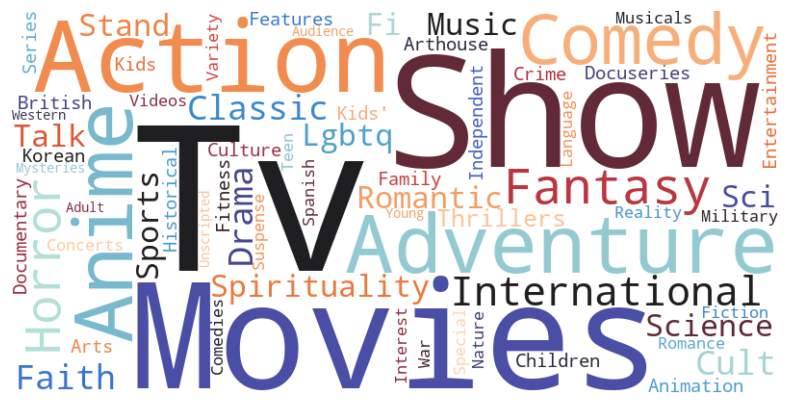

In [57]:
# Combinamos todas las categorías de la columna 'listed_in'
text = ' '.join(genero['listed_in'])

# Configuramos la nube de palabras
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='icefire',  
).generate(text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear') # Interpolation: calcular los valores de los píxeles en una imagen cuando se redimensiona
plt.axis('off')  # Ocultar los ejes
plt.show()

### Top 10 Géneros más Relevantes en Ambas Plataformas

El gráfico refleja que Drama es el género con mayor representación, seguido por Comedia e International Movies.

In [58]:
genero = genero.sort_values(by=['Total'], ascending=False)

top10_generos = genero.head(10)

print(top10_generos)

                 listed_in  Total
19                   Drama   6015
14                  Comedy   3680
30    International Movies   2752
17             Documentary   1779
0                   Action   1615
54                Suspense   1439
31  International Tv Shows   1350
32                    Kids   1056
49        Special Interest    892
1       Action & Adventure    859


C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\2564301684.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


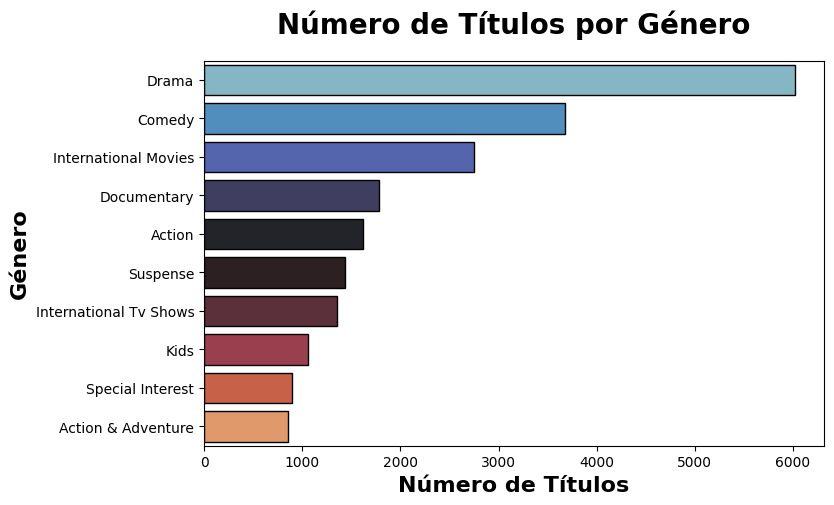

In [59]:
plt.figure(figsize=(8,5))

sns.countplot(
    y = 'listed_in',
    order=top10_generos['listed_in'],
    data=df_listed_in,
    palette= "icefire", 
    edgecolor='black'
)


plt.title('Número de Títulos por Género', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Número de Títulos', fontsize=16, fontweight='bold')
plt.ylabel('Género', fontsize=16, fontweight='bold')


plt.show()


### Top 10 Géneros más Relevantes por Plataforma

Prime Video tiene una clara ventaja en géneros como Drama, Comedia, Suspense, y Kids. Y Netflix se destaca por su gran cantidad de títulos en International Movies, International TV Shows, y Action & Adventure.

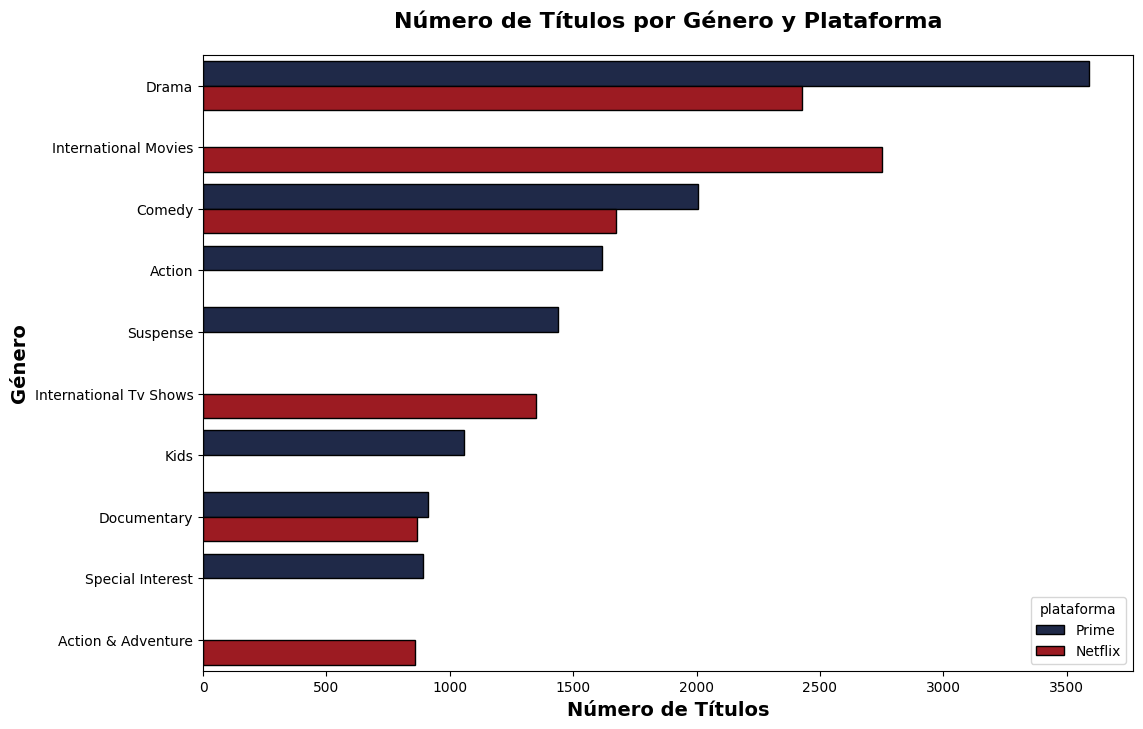

In [60]:
# Si no están en formato de lista, conviértelos a listas
df_final['listed_in'] = df_final['listed_in'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Explode la columna 'listed_in' para que cada género tenga su propia fila
df_exploded = df_final.explode('listed_in')


exclude_genres = ['TV Shows']


df_exploded  = df_exploded [~df_exploded ['listed_in'].isin(exclude_genres)]


df_exploded['listed_in'] = df_exploded['listed_in'].str.strip().str.title()


grouped_data = df_exploded.groupby(['listed_in', 'plataforma']).size().reset_index(name='count')




# Mapea variaciones a un nombre común
genre_mapping = { 
    'Dramas': 'Drama',
    'Comedies': 'Comedy',
    'Documentaries': 'Documentary'
}
grouped_data['listed_in'] = grouped_data['listed_in'].map(genre_mapping).fillna(grouped_data ['listed_in'])


sorted_data = grouped_data.sort_values(by='count', ascending=False)


top_genres = sorted_data['listed_in'].unique()[:10] # Seleccióna los 10 primeros géneros únicos


df_top_genres = sorted_data[sorted_data['listed_in'].isin(top_genres)]


plt.figure(figsize=(12, 8))


sns.barplot(
    data=df_top_genres,
    y='listed_in',
    x='count',
    hue='plataforma',
    order=top_genres,
    palette= PALETA,
    edgecolor = 'black'
)


plt.title('Número de Títulos por Género y Plataforma', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Número de Títulos', fontsize=14, fontweight='bold')
plt.ylabel('Género', fontsize=14, fontweight='bold')

plt.show()



### Distribución de los Años de Lanzamiento de los Títulos Añadidos por Plataforma

La mayoría de los títulos de ambas plataformas se han lanzado desde el año 2000, con un crecimiento exponencial hacia los años más recientes.

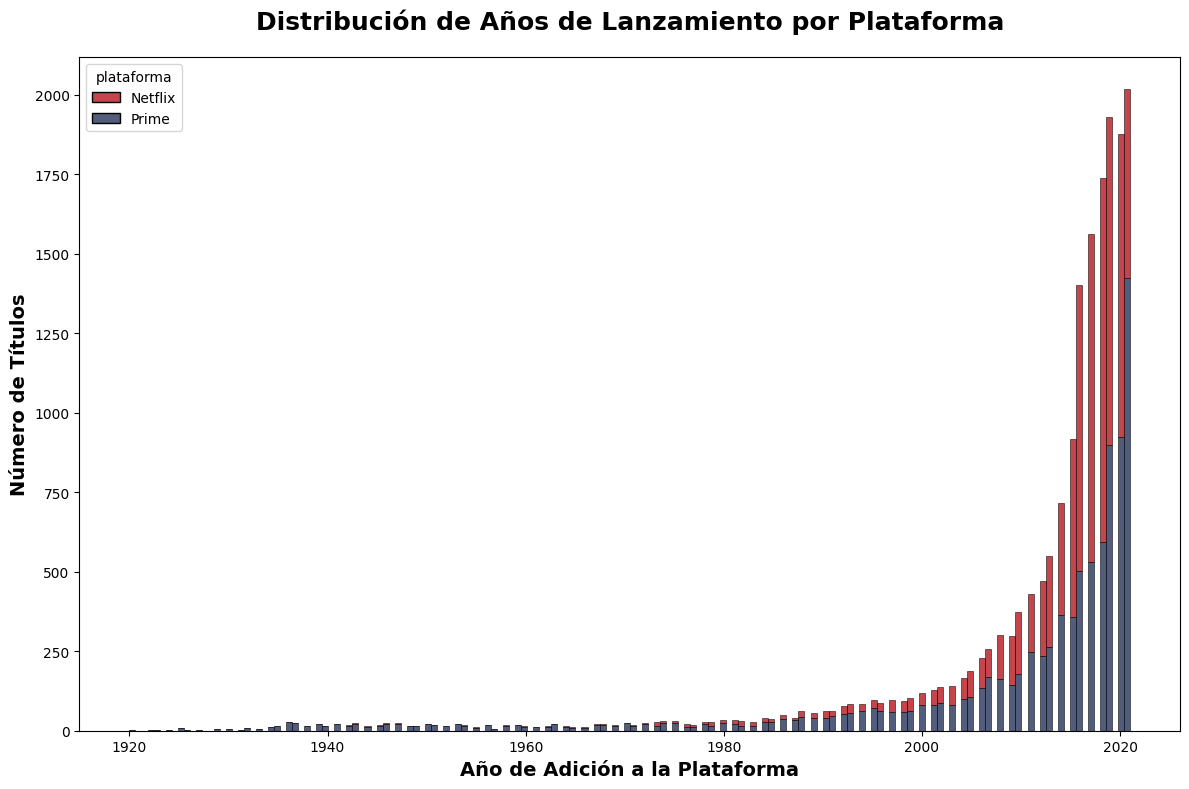

In [61]:
plt.figure(figsize=(12, 8))

sns.histplot(
    data=df_final,
    x='release_year',
    hue='plataforma',
    multiple='stack',
    palette=PALETA,
    edgecolor='black'
)

plt.title('Distribución de Años de Lanzamiento por Plataforma', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Año de Adición a la Plataforma', fontsize=14, fontweight='bold')
plt.ylabel('Número de Títulos', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

``NOTA``: Como las columnas **director**, **cast** y **country** son de la misma forma que la columna **listed_in**, vamos a generalizar el código en funciones, siguiendo como ejemplo lo hecho para **listed_in**.

### Top 10 Directores más Relevantes en Ambas Plataformas

Existe una diferencia notable entre los primeros directores (Mark Knight y Cannis Holder) y los demás, reflejando una gran concentración de títulos en estos dos primeros.

C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\1473839582.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


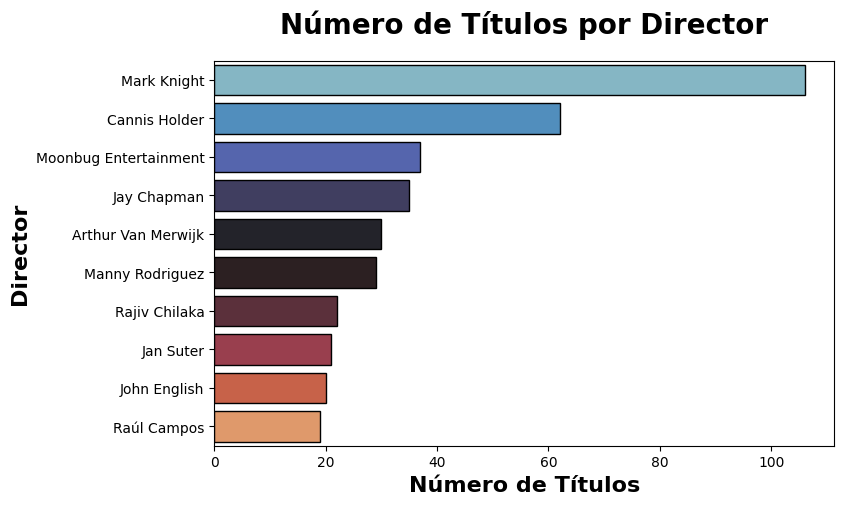

In [62]:
top_10_general(
    df=df_final,
    category_col='director',
    top_n=10,  
    exclude_categories=['Sin Especificar'],  # Categorías a excluir
    palette='icefire' 
)


### Top 10 Directores más Relevantes por Plataforma

Mark Knight es el director con más ocurrencias en la plataforma Prime. Rajiv Chilaka y Raúl Campos tienen una fuerte presencia en Netflix, con más de 20 ocurrencias cada uno.Jay Chapman, aunque aparece en ambas plataformas, tiene una mayor presencia en Netflix que en Prime.

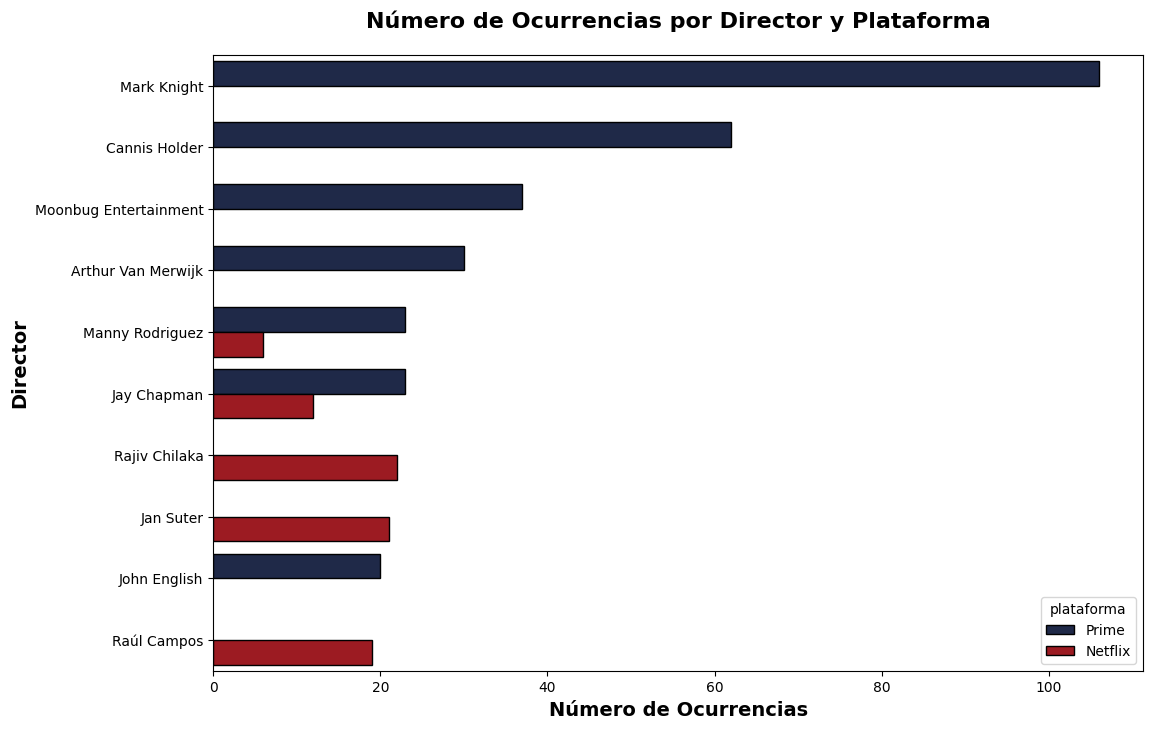

In [63]:
top_10_por_plataforma(
    df=df_final,
    category_col='director', 
    group_col='plataforma',  
    top_n=10,  
    exclude_categories=['Sin especificar'], 
    palette=PALETA
)
    

### Top 10 Actores/Actrices de Reparto más Relevantes en Ambas Plataformas

En la siguiente gráfica se representa el número de títulos en los que han participado distintos miembros del cast. Este gráfico refleja que Anupam Kher y Maggie Binkley son los actores más prolíficos en términos de cantidad de títulos.

C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\1473839582.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


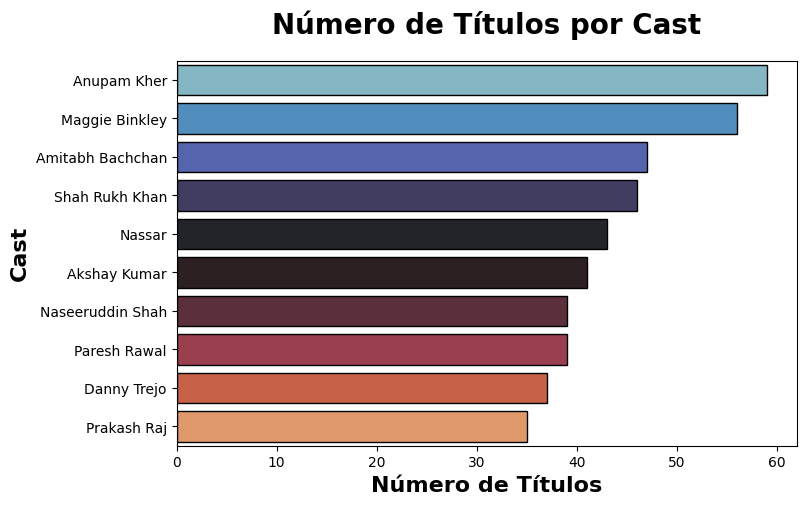

In [64]:
top_10_general(
    df=df_final,
    category_col='cast',
    top_n=10,  
    exclude_categories=['Sin Especificar'],  
    palette='icefire'  
)

### Top 10 Actores/Actrices de Reparto más Relevantes por Plataforma

El gráfico muestra que Netflix tiene más títulos en su mayoría de actores en comparación con Prime, esto indica que el contenido de estos actores es más frecuente en Netflix.

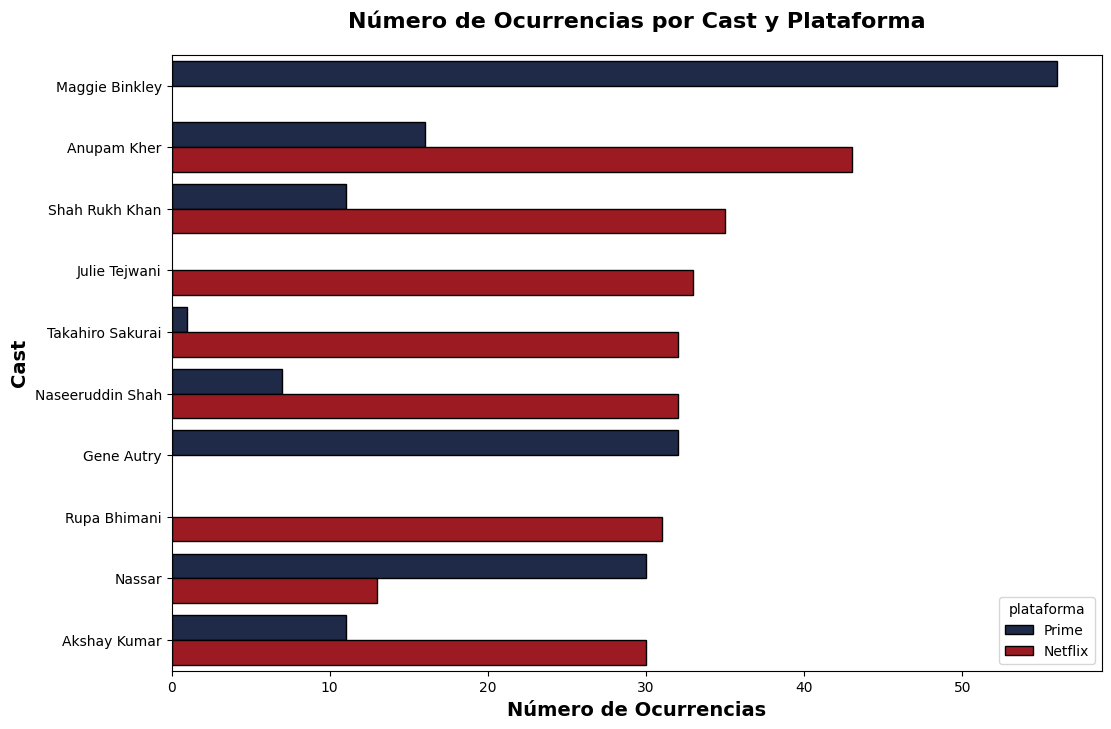

In [65]:
top_10_por_plataforma(
    df=df_final,
    category_col='cast', 
    group_col='plataforma',  
    top_n=10,  
    exclude_categories=['Sin especificar', '1'], 
    palette=PALETA
)

### Top 10 Países de Producción más Relevantes en Ambas Plataformas

La producción de contenido de Netflix está dominada por los Estados Unidos, lo cual es consistente con la gran cantidad de estudios y compañías de producción ubicadas allí. India y el Reino Unido también son grandes centros de producción, lo que refleja la popularidad del cine de Bollywood y la industria televisiva británica. Además, otros países como Japón y Corea del Sur están representados, posiblemente debido a la creciente popularidad del contenido asiático en la plataforma, como el anime y los dramas coreanos.

C:\Users\esthe\AppData\Local\Temp\ipykernel_28712\1473839582.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


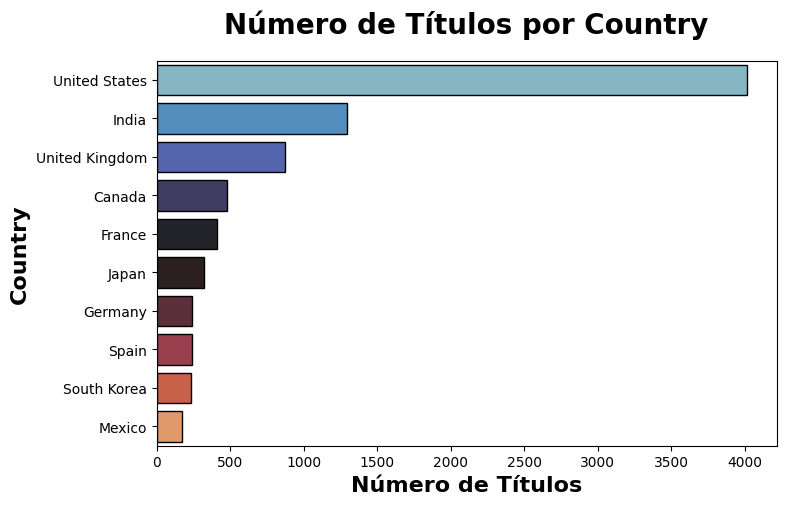

In [66]:
top_10_general(
    df=df_final,
    category_col='country',
    top_n=10,  
    exclude_categories=['Sin Especificar'], 
    palette='icefire'  
)

### Top 10 Países de Producción más Relevantes por Plataforma

Resalta la dominancia de Netflix en términos de cantidad de títulos disponibles por país.

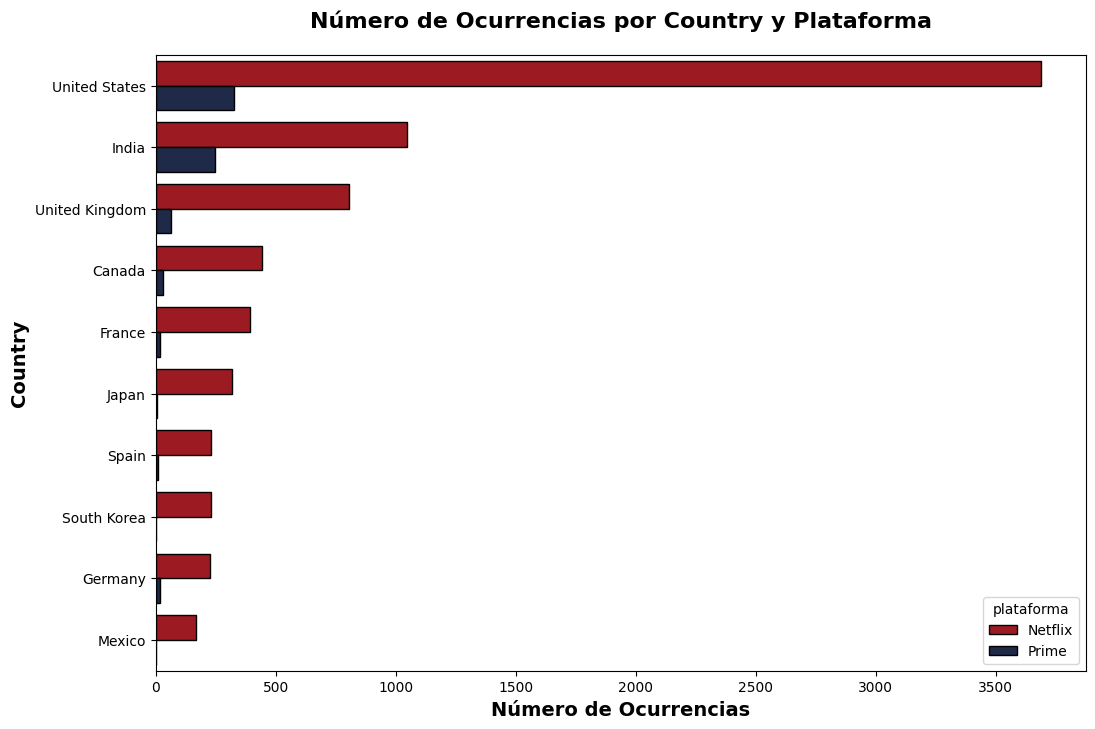

In [67]:

top_10_por_plataforma(
    df=df_final,
    category_col='country', 
    group_col='plataforma',  
    top_n=10,  
    exclude_categories=['Sin especificar'], 
    palette=PALETA
)

### Países de Producción en Ambas Plataformas

La densidad de contenido parece estar concentrada en Norteamérica, partes de Europa y Asia.

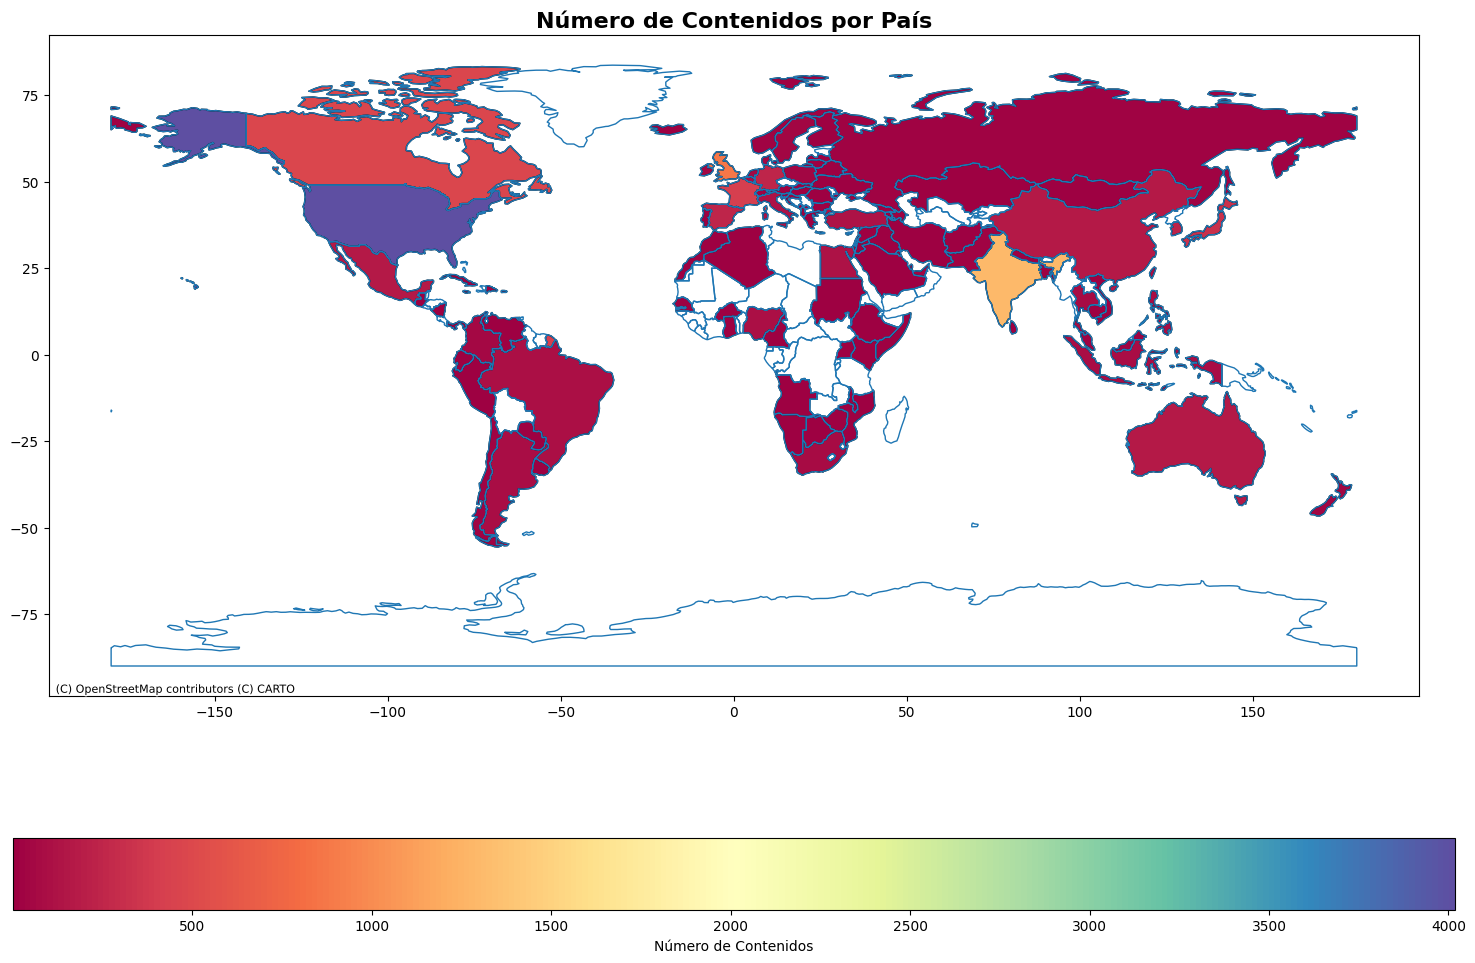

In [68]:
world['SOVEREIGNT'] = world['SUBUNIT']



df_country = pd.DataFrame()

df_country = df_final['country'].str.split(',', expand = True).stack()
df_country = df_country.to_frame()
df_country.columns = ['country']


df_country['country'] = df_country['country'].str.strip()

country = df_country.groupby(['country']).size().reset_index(name = 'Total')

# Filtrar para eliminar los valores 'Sin especificar'
country = country[~country['country'].isin(['Sin especificar'])]


world = world.rename(columns={'SOVEREIGNT': 'country'})

#Por si hay espacios adicionales en las columnas 'country'
country['country'] = country['country'].str.strip()
world['country'] = world['country'].str.strip()

merged = world.set_index('country').join(country.set_index('country'))


fig, ax = plt.subplots(1, 1, figsize=(15, 10))


ax.set_facecolor('white')

# Mostrar el contorno de los países
world.boundary.plot(ax=ax, linewidth=1)

# Mostrar el contenido en el mapa
merged.plot(column='Total', ax=ax, legend=True,
            legend_kwds={'label': "Número de Contenidos",
                         'orientation': "horizontal"},
            cmap='Spectral', edgecolor='black')

# Añadir el mapa base para mejorar la visualización
ctx.add_basemap(ax, crs=world.crs.to_string(), source=ctx.providers.CartoDB.Positron)


plt.title('Número de Contenidos por País', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Clasificación por Edad por Plataforma

Prime tiene una mayor presencia en las clasificaciones sin edad específica y contenido más orientado a la familia (0+, 7+, sin clasificación). Por otro lado, Netflix lidera en el contenido más orientado a adultos (18+). En cuanto a la categoría de 13+ hay un equilibrio con ambas plataformas casi al 50%.

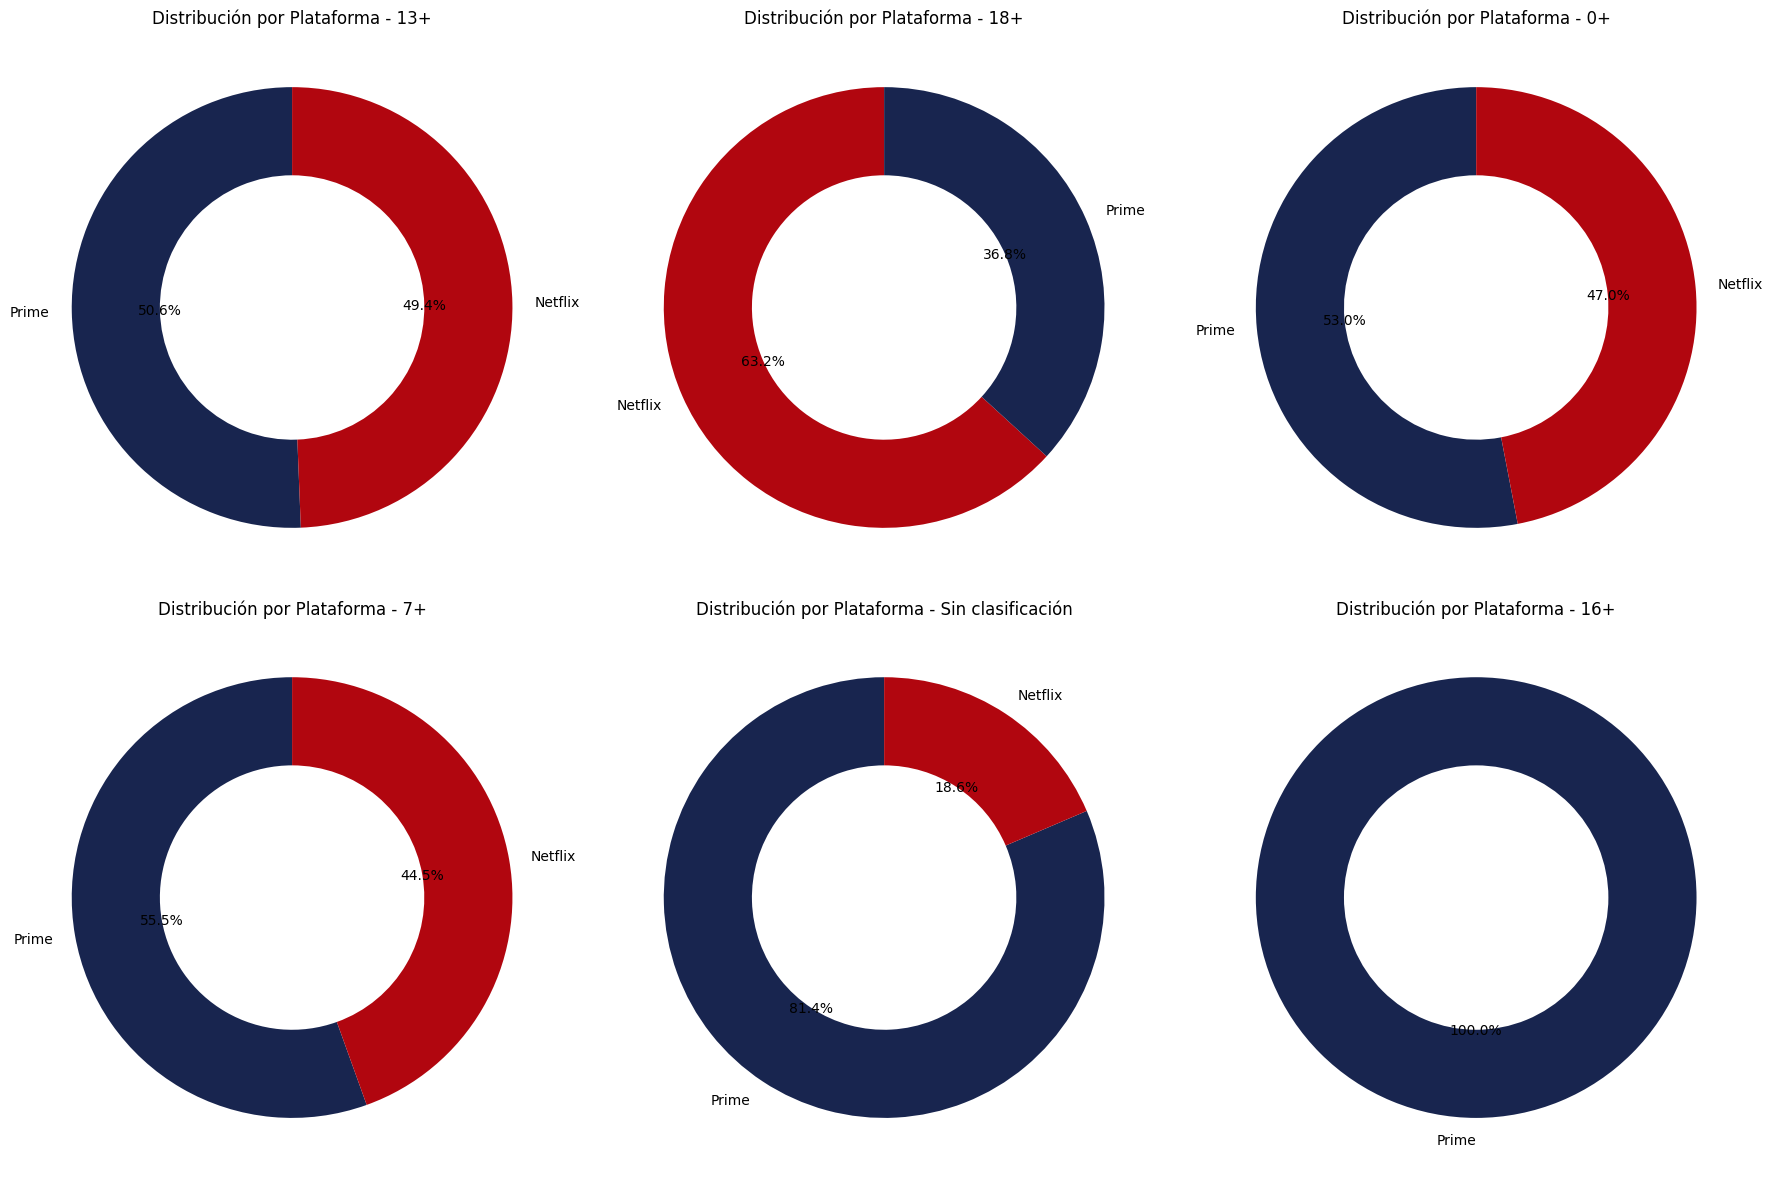

In [69]:
#Obtén las categorías de edad únicas
categorias_edad = df_final['edad_categoria'].unique()


fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten() 

# Itera sobre cada categoría de edad y crea un gráfico de donuts
for i, categoria in enumerate(categorias_edad):
    
    df_categoria = df_final[df_final['edad_categoria'] == categoria]
    
    
    conteo_plataformas = df_categoria['plataforma'].value_counts()
    
    
    porcentajes = conteo_plataformas / conteo_plataformas.sum() * 100

   
    colores_segmentos = [PALETA[plataforma] for plataforma in porcentajes.index]
    
    
    wedges, texts, autotexts = axes[i].pie(porcentajes, labels=porcentajes.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4), colors=colores_segmentos)
    
    
    axes[i].set_title(f'Distribución por Plataforma - {categoria}')


plt.tight_layout()
plt.show()

### Distribución de Duración en Minutos por Plataforma

Ambas plataformas tienden a ofrecer títulos que duran entre 60 y 120 minutos, lo cual es común para películas y algunos programas especiales. La diferencia se evidencia principalmente en Netflix, que parece ofrecer más contenido de mayor duración en comparación con Prime.

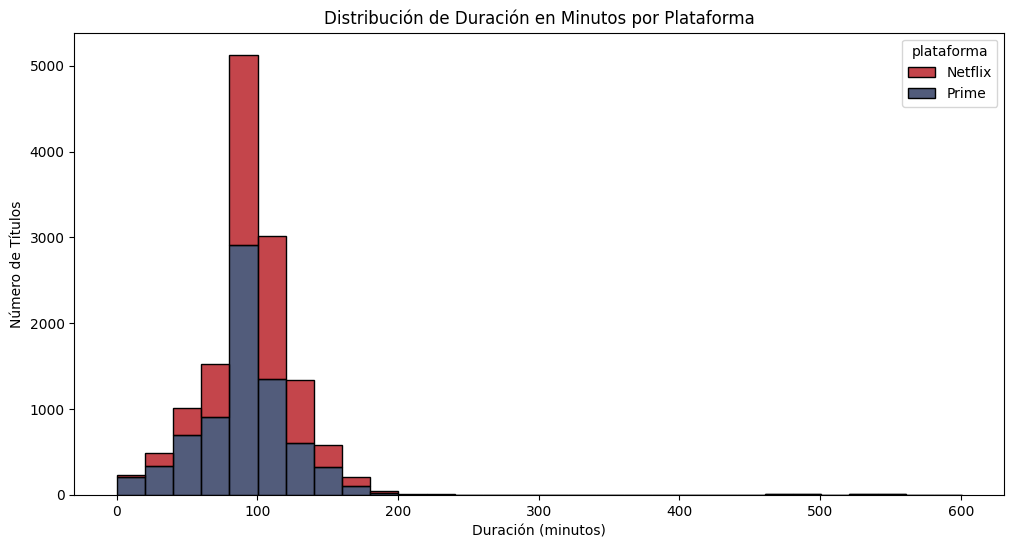

In [70]:
# Filtrar el DataFrame
df_pelis = df_final[df_final['duration_unit'] == 'min']

plt.figure(figsize=(12, 6))
sns.histplot(data=df_pelis, x='duration_value', hue='plataforma', multiple='stack', bins=30, palette=PALETA)
plt.title('Distribución de Duración en Minutos por Plataforma')
plt.xlabel('Duración (minutos)')
plt.ylabel('Número de Títulos')
plt.show()

### Distribución de Duración por Temporadas por Plataforma

ambos servicios de streaming tienen una gran cantidad de títulos con temporadas cortas (de menos de 5 temporadas), lo que podría indicar una tendencia hacia contenidos más breves o formatos de episodios de corta duración.

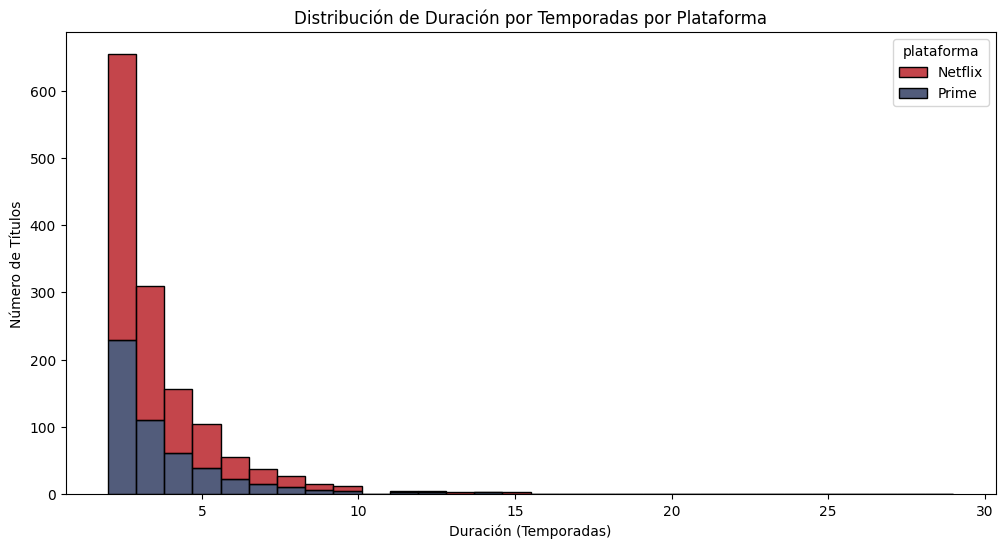

In [71]:
# Filtrar el DataFrame
df_series = df_final[df_final['duration_unit'] == 'Seasons']

plt.figure(figsize=(12, 6))
sns.histplot(data=df_series, x='duration_value', hue='plataforma', multiple='stack', bins=30, palette=PALETA)
plt.title('Distribución de Duración por Temporadas por Plataforma')
plt.xlabel('Duración (Temporadas)')
plt.ylabel('Número de Títulos')
plt.show()


### Duración de las Peliculas y Series por Plataforma

En ambas plataformas hay películas que superan los 300 minutos, con algunas en Netflix que incluso superan los 600 minutos, lo que las convierte en valores atípicos muy altos. En cuanto a las series, en Prime Video, se observa una serie con alrededor de 30 temporadas, lo cual es un valor atípico importante.

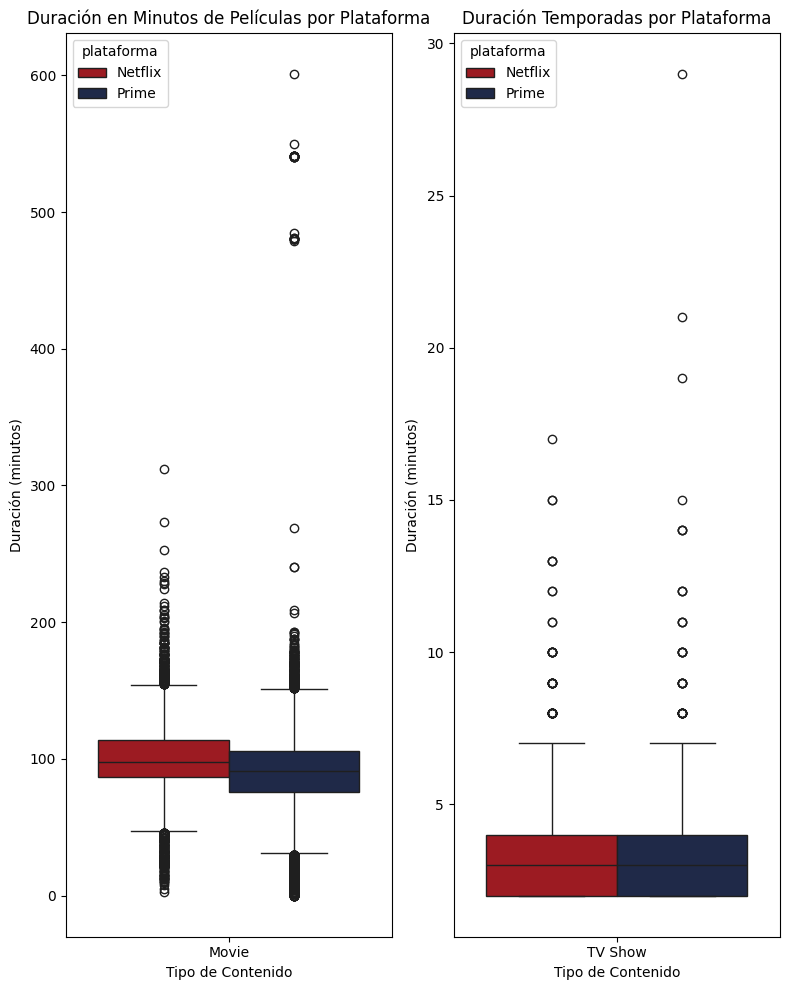

In [72]:
# Filtrar el DataFrame para películas y series
# df_pelis = df_final[df_final['type'] == 'Movie']
# df_series = df_final[df_final['type'] == 'TV Show']


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 10))

# Duración de películas por plataforma
sns.boxplot(data=df_pelis, x='type', y='duration_value', hue='plataforma', ax=axes[0], palette=PALETA)
axes[0].set_title('Duración en Minutos de Películas por Plataforma')
axes[0].set_xlabel('Tipo de Contenido')
axes[0].set_ylabel('Duración (minutos)')

# Duración de series por plataforma
sns.boxplot(data=df_series, x='type', y='duration_value', hue='plataforma', ax=axes[1], palette=PALETA)
axes[1].set_title('Duración Temporadas por Plataforma')
axes[1].set_xlabel('Tipo de Contenido')
axes[1].set_ylabel('Duración (minutos)')


plt.tight_layout()


plt.show()

## 8. Conclusiones 

Poniendo en conjunto todo lo que hemos visto en nuestro estudio, podemos sacar las siguientes conclusiones:

Netflix y Prime Video tienen un número similar de títulos, pero Prime Video ofrece más películas, mientras que Netflix tiene más programas de TV. Desde 2016, ambas plataformas han añadido muchos títulos, aunque Netflix ha mantenido un ritmo de crecimiento más constante.

Diversidad de Géneros: Netflix se destaca en títulos internacionales y géneros como Acción y Aventura, mientras que Prime Video lidera en Drama, Comedia y contenido infantil.

Producción y Distribución Regional: Netflix tiene una mayor concentración de títulos producidos en EE.UU., mientras que Prime Video presenta más contenido familiar y sin clasificación específica.

Directores y Actores: Netflix tiene mayor diversidad de títulos dirigidos por varios directores y actores frecuentes como Anupam Kher, mientras que Prime Video muestra más concentración en ciertos nombres.

Duración del Contenido: Ambas plataformas prefieren películas y series de entre 60 y 120 minutos, aunque Netflix ofrece más títulos de larga duración y contenido para adultos (18+).

Conclusión: Netflix y Prime Video compiten con diferentes estrategias: Netflix ofrece mayor diversidad y contenido internacional, mientras que Prime Video se enfoca más en películas y contenido familiar.

## 9. Resumen

Para finalizar, en este proyecto se llevarón a cabo un análisis comparativo de los catálogos de Netflix y Amazon Prime Video, utilizando datasets que incluían detalles sobre el contenido, como tipo, título, actores, directores, país de producción, fecha de adición, año de lanzamiento, clasificación, duración, género y sinopsis. Tras importar y explorar los datos, se aplicaron técnicas de limpieza y transformación para preparar los datos para un análisis detallado. Se unieron los datasets y se realizaron visualizaciones que permitieron identificar patrones y diferencias clave entre las dos plataformas.

# Referencias

Datasets:
- https://www.kaggle.com/datasets/shivamb/netflix-shows
- https://www.kaggle.com/datasets/shivamb/amazon-prime-movies-and-tv-shows
- https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

Documentación:
- https://seaborn.pydata.org/tutorial.html
- https://pandas.pydata.org/docs/user_guide/index.html#user-guide
- https://matplotlib.org/stable/users/index.html#
- https://numpy.org/numpy-tutorials/
- https://docs.python.org/es/3/tutorial/

- https://docs.python.org/3/library/calendar.html
- https://seaborn.pydata.org/tutorial/color_palettes.html
- https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py
- https://dataviz.unhcr.org/tools/python/python_donut_chart.html
- https://geopandas.org/en/stable/docs/user_guide/mapping.html